## Retinal Disease Classification
Our previous models had an accuracy of literaly 0 - So here are some end-to-end CNNs for comparison

## Setup & Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/DL Final Project
base_data_path = "/content/drive/MyDrive/DL Final Project/STARE_cleaned/"

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1uPpg4Yr8uev2brz5QIGI5ObT-zin6hvX/DL Final Project


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

## Dataset

In [ ]:
def random_flip(img: torch.Tensor):
    if random.random() > 0.5:
        img = TF.hflip(img)
    if random.random() > 0.5:
        img = TF.vflip(img)
    return img

def augment_image(image_tensor):
  variations = []
  variations.append(random_flip(image_tensor))
  return variations

In [ ]:
class AugmentedImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, augment_fn=None, transform=None):
        """
        Combines classification data loading (CSV) with augmentation.
        Args:
            annotations_file: Path to CSV with [filename, label]
            img_dir: Directory containing images
            augment_fn: Function returning list of (img, mask) variations
            transform: Base transform to apply before augmentation (must return Tensor)
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.augment_fn = augment_fn
        self.samples = []

        print(f"Processing dataset from {annotations_file}...")

        # Pre-load and augment data (eager loading)
        for idx in tqdm(range(len(self.img_labels)), desc="Pre-loading data"):
            img_name = str(self.img_labels.iloc[idx, 0])
            label_vector = self.img_labels.iloc[idx, 1:].values.astype('float32')
            label = torch.tensor(label_vector)

            # Construct path
            img_path = os.path.join(self.img_dir, img_name)
            if not os.path.exists(img_path):
                if os.path.exists(img_path + '.png'):
                    img_path += '.png'
                else:
                    continue

            image = Image.open(img_path).convert("RGB")

            # Apply base transform (Resize, ToTensor)
            if self.transform:
                img_tensor = self.transform(image)
            else:
                img_tensor = TF.to_tensor(image)


            self.samples.append((img_tensor, label))
            # Apply Augmentations if provided
            if self.augment_fn:
                variations = self.augment_fn(img_tensor)
                for aug_img in variations:
                    self.samples.append((aug_img, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
train_csv = base_data_path + 'train_labels.csv'
train_img_dir = base_data_path + 'train_images'


test_csv = base_data_path + 'test_labels.csv'
test_img_dir = base_data_path + 'test_images'

resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = AugmentedImageDataset(
    annotations_file=train_csv,
    img_dir=train_img_dir,
    augment_fn=augment_image,
    transform=resize_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = AugmentedImageDataset(
    annotations_file=test_csv,
    img_dir=test_img_dir,
    augment_fn=None,
    transform=resize_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/train_labels.csv...


Pre-loading data: 100%|██████████| 214/214 [02:57<00:00,  1.20it/s]


Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/test_labels.csv...


Pre-loading data: 100%|██████████| 93/93 [01:58<00:00,  1.27s/it]


Train dataset size: 428
Test dataset size: 93


## Resnet

Results:
Subset Accuracy: 0.3656
Hamming Loss: 0.0607
Macro F1: 0.4493
Micro F1: 0.5093
Macro AUC: 0.8981

In [ ]:
class ResNetClassifier(nn.Module):
    """ResNet-18 pretrained on ImageNet, fine-tuned for retinal diseases"""
    def __init__(self, num_classes=14, pretrained=True):
        super().__init__()

        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=pretrained)

        # Replace final layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

#### Training

In [ ]:
def train_classifier(model, train_loader, val_loader, num_epochs=30, lr=1e-4, device='cuda', task='multilabel'):
    """
    Trains a classification model using AdamW, BCEWithLogitsLoss, and early stopping.

    Parameters:
    - model : torch.nn.Module
    - train_loader : torch.utils.data.DataLoader
    - val_loader : torch.utils.data.DataLoader
    - num_epochs : int, optional
    - lr : float, optional
    - device : str, optional
    - task : str, optional

    Returns
    tuple
        A tuple containing:
        - model (torch.nn.Module): The best trained model.
        - history (dict): Training and validation metrics per epoch.
    """
    model = model.to(device)

    # not sure what this is for
    if task == 'multilabel':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 7

    print(f"Training on {device}")
    print(f"Task: {task}")
    print(f"Epochs: {num_epochs}")
    print(f"Learning rate: {lr}")
    print()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        #pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            # Forward
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()

            # Track
            train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            train_preds.append(preds.detach().cpu().numpy())
            train_labels.append(labels.cpu().numpy())

            #pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Compute train metrics
        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)
        train_loss /= len(train_loader)

        if task == 'multilabel':
            train_acc = accuracy_score(train_labels, train_preds)  # Subset accuracy
        else:
            train_acc = accuracy_score(train_labels.ravel(), train_preds.ravel())

        # ========== VALIDATION ==========
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                val_preds.append(preds.cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        # Compute val metrics
        val_preds = np.vstack(val_preds)
        val_labels = np.vstack(val_labels)
        val_loss /= len(val_loader)

        if task == 'multilabel':
            val_acc = accuracy_score(val_labels, val_preds)
        else:
            val_acc = accuracy_score(val_labels.ravel(), val_preds.ravel())

        # Update scheduler
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: ||| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"\tVal Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_resnet_classifier.pth')
            print("  ✓ Saved best model")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('best_resnet_classifier.pth'))
    return model, history

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = ResNetClassifier(num_classes=14, pretrained=True)

resnet_model, resnet_history = train_classifier(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=30,
    lr=1e-4,
    device=device,
    task='multilabel'
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Training on cuda
Task: multilabel
Epochs: 30
Learning rate: 0.0001

Epoch 1/30: ||| Train Loss: 0.6726 | Train Acc: 0.0023
	Val Loss:   0.5374 | Val Acc:   0.0215
  ✓ Saved best model
Epoch 2/30: ||| Train Loss: 0.4228 | Train Acc: 0.1005
	Val Loss:   0.3621 | Val Acc:   0.2366
  ✓ Saved best model
Epoch 3/30: ||| Train Loss: 0.2926 | Train Acc: 0.3131
	Val Loss:   0.2885 | Val Acc:   0.2258
  ✓ Saved best model
Epoch 4/30: ||| Train Loss: 0.2239 | Train Acc: 0.4533
	Val Loss:   0.2540 | Val Acc:   0.2688
  ✓ Saved best model
Epoch 5/30: ||| Train Loss: 0.1671 | Train Acc: 0.6028
	Val Loss:   0.2364 | Val Acc:   0.2688
  ✓ Saved best model
Epoch 6/30: ||| Train Loss: 0.1344 | Train Acc: 0.7150
	Val Loss:   0.2217 | Val Acc:   0.3011
  ✓ Saved best model
Epoch 7/30: ||| Train Loss: 0.1055 | Train Acc: 0.8294
	Val Loss:   0.2128 | Val Acc:   0.2903
  ✓ Saved best model
Epoch 8/30: ||| Train Loss: 0.0909 | Train Acc: 0.8808
	Val Loss:   0.2121 | Val Acc:   0.2688
  ✓ Saved best model
Epoc

In [ ]:
def plot_training_history(history):
    """Plot loss and accuracy curves"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    return fig

#### Evaluation

In [ ]:
def evaluate_model(model, test_loader, device='cuda', task='multilabel'):
    """Full evaluation with all metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    metrics = {}

    if task == 'multilabel':
        # Multi-label metrics
        metrics['subset_accuracy'] = accuracy_score(all_labels, all_preds)
        metrics['hamming_loss'] = np.mean(all_preds != all_labels)

        # Per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            all_labels, all_preds, average=None, zero_division=0
        )

        metrics['per_class_precision'] = precision
        metrics['per_class_recall'] = recall
        metrics['per_class_f1'] = f1
        metrics['per_class_support'] = support

        # Averages
        metrics['macro_f1'] = np.mean(f1)
        metrics['micro_precision'], metrics['micro_recall'], metrics['micro_f1'], _ = \
            precision_recall_fscore_support(all_labels, all_preds, average='micro', zero_division=0)

        # AUC per class
        try:
            aucs = []
            for i in range(all_labels.shape[1]):
                if len(np.unique(all_labels[:, i])) > 1:
                    auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
                    aucs.append(auc)
                else:
                    aucs.append(np.nan)
            metrics['per_class_auc'] = np.array(aucs)
            metrics['macro_auc'] = np.nanmean(aucs)
        except:
            metrics['per_class_auc'] = None
            metrics['macro_auc'] = None

    else:  # binary
        metrics['accuracy'] = accuracy_score(all_labels.ravel(), all_preds.ravel())
        metrics['precision'], metrics['recall'], metrics['f1'], _ = \
            precision_recall_fscore_support(all_labels.ravel(), all_preds.ravel(), average='binary')
        try:
            metrics['auc'] = roc_auc_score(all_labels.ravel(), all_probs.ravel())
        except:
            metrics['auc'] = None

    return metrics, all_preds, all_labels, all_probs

Evaluating: 100%|██████████| 3/3 [00:00<00:00, 69.42it/s]



FINAL RESULTS
Subset Accuracy: 0.3656
Hamming Loss: 0.0630
Macro F1: 0.4793
Micro F1: 0.5060
Macro AUC: 0.8923


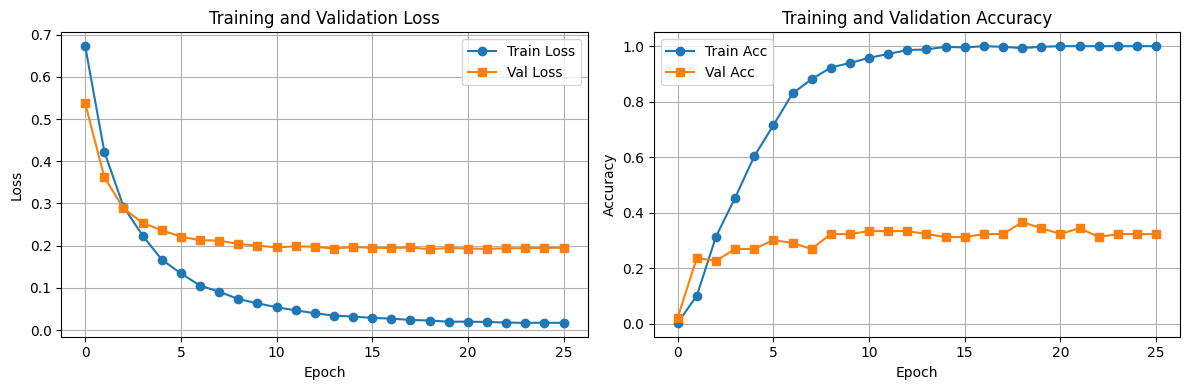

In [ ]:
# Evaluate
resnet_metrics, preds, labels, probs = evaluate_model(
    resnet_model, test_loader, device=device, task='multilabel'
)

# Print results
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Subset Accuracy: {resnet_metrics['subset_accuracy']:.4f}")
print(f"Hamming Loss: {resnet_metrics['hamming_loss']:.4f}")
print(f"Macro F1: {resnet_metrics['macro_f1']:.4f}")
print(f"Micro F1: {resnet_metrics['micro_f1']:.4f}")
if resnet_metrics['macro_auc']:
    print(f"Macro AUC: {resnet_metrics['macro_auc']:.4f}")

fig = plot_training_history(resnet_history)
plt.show(fig)

## EfficientNet-B0

In [ ]:
class EfficientNetClassifier(nn.Module):
    """EfficientNet-B0 - usually better than ResNet for medical images"""
    def __init__(self, num_classes=14, pretrained=True, dropout=0.5):
        super().__init__()

        # Load pretrained
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        num_features = self.backbone.classifier[1].in_features

        # Replace classifier with better architecture
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout/2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
class ConvNeXtClassifier(nn.Module):
    """ConvNeXt-Tiny - Modern CNN, often beats EfficientNet"""
    def __init__(self, num_classes=14, pretrained=True, dropout=0.5):
        super().__init__()

        # Load pretrained ConvNeXt
        self.backbone = models.convnext_tiny(pretrained=pretrained)
        num_features = self.backbone.classifier[2].in_features

        # Replace classifier
        self.backbone.classifier[2] = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout/2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

#### Trying New Loss Options - Focal & Weighted BCE

In [ ]:
class FocalLoss(nn.Module):
    """
    Focal Loss for multi-label classification
    Focuses learning on hard examples and rare classes

    Formula: FL = -α(1-p)^γ * log(p)
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: (N, C) logits
            targets: (N, C) binary labels
        """
        # Get probabilities
        probs = torch.sigmoid(inputs)

        # Calculate focal weight
        # For positive class: α(1-p)^γ
        # For negative class: (1-α)p^γ
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma

        # Alpha balancing
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)

        # BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )

        # Focal loss
        focal_loss = alpha_t * focal_weight * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
class WeightedBCELoss(nn.Module):
    """
    BCE with per-class weights for imbalanced datasets
    Automatically computed from class frequencies
    """
    def __init__(self, pos_weights=None):
        super().__init__()
        self.pos_weights = pos_weights

    def forward(self, inputs, targets):
        if self.pos_weights is not None:
            return F.binary_cross_entropy_with_logits(
                inputs, targets, pos_weight=self.pos_weights
            )
        else:
            return F.binary_cross_entropy_with_logits(inputs, targets)


In [ ]:
def compute_class_weights(train_loader, num_classes=14, device='cuda'):
    """
    Compute positive class weights for imbalanced datasets
    Weight = (total_samples - positive_samples) / positive_samples
    """
    positive_counts = torch.zeros(num_classes)
    total_samples = 0

    for _, labels in tqdm(train_loader, desc="Computing class weights"):
        positive_counts += labels.sum(dim=0)
        total_samples += labels.shape[0]

    # Compute weights
    negative_counts = total_samples - positive_counts
    pos_weights = negative_counts / (positive_counts + 1e-5)  # Avoid division by zero

    # Clip extreme weights
    pos_weights = torch.clamp(pos_weights, min=0.5, max=50.0)

    print("\nClass distribution and weights:")
    for i in range(num_classes):
        print(f"  Class {i}: {int(positive_counts[i])} samples, weight: {pos_weights[i]:.2f}")

    return pos_weights.to(device)

#### Training

In [ ]:
def train_classifier_v2(model, train_loader, val_loader,
                        num_epochs=30, lr=1e-4, device='cuda',
                        loss_type='focal', class_weights=None):
    """
    Parameters:
        loss_type: 'bce', 'weighted_bce', or 'focal'
        class_weights: Optional tensor of per-class weights
    """
    model = model.to(device)

    # Choose loss function - experiments
    if loss_type == 'focal':
        criterion = FocalLoss(alpha=0.25, gamma=2.0)
        print("Using Focal Loss (handles imbalance)")
    elif loss_type == 'weighted_bce':
        if class_weights is None:
            class_weights = compute_class_weights(train_loader, device=device)
        criterion = WeightedBCELoss(pos_weights=class_weights)
        print("Using Weighted BCE Loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
        print("Using standard BCE Loss")

    # Optimizer using whatever weight decay is
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # Cosine annealing scheduler (often better than ReduceLROnPlateau)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=1e-6
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_macro_f1': [], 'val_macro_auc': []
    }

    best_val_f1 = 0.0
    patience_counter = 0
    early_stop_patience = 10

    print(f"\nTraining Configuration:")
    print(f"  Device: {device}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning rate: {lr}")
    print(f"  Loss: {loss_type}")
    print()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        #pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping (prevents exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            train_preds.append(preds.detach().cpu().numpy())
            train_labels.append(labels.cpu().numpy())

            #pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)
        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)

        # ========== VALIDATION ==========
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        val_probs = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False):
                images = images.to(device)
                labels = labels.float().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                val_preds.append(preds.cpu().numpy())
                val_labels.append(labels.cpu().numpy())
                val_probs.append(probs.cpu().numpy())

        val_preds = np.vstack(val_preds)
        val_labels = np.vstack(val_labels)
        val_probs = np.vstack(val_probs)
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        # Compute F1 and AUC
        _, _, f1_scores, _ = precision_recall_fscore_support(
            val_labels, val_preds, average=None, zero_division=0
        )
        val_macro_f1 = np.mean(f1_scores)

        try:
            aucs = []
            for i in range(val_labels.shape[1]):
                if len(np.unique(val_labels[:, i])) > 1:
                    aucs.append(roc_auc_score(val_labels[:, i], val_probs[:, i]))
            val_macro_auc = np.mean(aucs) if aucs else 0.0
        except:
            val_macro_auc = 0.0

        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_macro_f1'].append(val_macro_f1)
        history['val_macro_auc'].append(val_macro_auc)

        # Print
        print(f"Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.6f}):")
        print(f"\tTrain: Loss={train_loss:.4f}, Acc={train_acc:.4f}")
        print(f"\tVal:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_macro_f1:.4f}, AUC={val_macro_auc:.4f}")

        # Save best model based on F1
        if val_macro_f1 > best_val_f1:
            best_val_f1 = val_macro_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_v2.pth')
            print("  ✓ New best F1! Model saved.")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        print("-"*60)

    # Load best model
    model.load_state_dict(torch.load('best_model_v2.pth'))
    return model, history


#### Ensemble Predictors & Evalutation

In [ ]:
class EnsembleClassifier:
    """Combine predictions from multiple models"""
    def __init__(self, models, weights=None):
        """
        Args:
            models: List of trained models
            weights: Optional list of weights (will use uniform if None)
        """
        self.models = models
        if weights is None:
            self.weights = [1.0 / len(models)] * len(models)
        else:
            self.weights = weights

    def predict(self, dataloader, device='cuda'):
        """Get ensemble predictions"""
        all_probs = []
        all_labels = None

        # Get predictions from each model
        for model, weight in zip(self.models, self.weights):
            model.eval()
            model_probs = []
            labels_list = []

            with torch.no_grad():
                for images, labels in tqdm(dataloader, desc="Ensemble predicting", leave=False):
                    images = images.to(device)
                    outputs = model(images)
                    probs = torch.sigmoid(outputs)
                    model_probs.append(probs.cpu().numpy())
                    labels_list.append(labels.numpy())

            model_probs = np.vstack(model_probs)
            all_probs.append(model_probs * weight)

            if all_labels is None:
                all_labels = np.vstack(labels_list)

        # Average predictions
        ensemble_probs = np.sum(all_probs, axis=0)
        ensemble_preds = (ensemble_probs > 0.5).astype(float)

        return ensemble_preds, all_labels, ensemble_probs

In [ ]:
def evaluate_ensemble(models, test_loader, device='cuda', weights=None):
    """Evaluate ensemble of models"""
    ensemble = EnsembleClassifier(models, weights)
    preds, labels, probs = ensemble.predict(test_loader, device)

    # Compute metrics
    metrics = {}
    metrics['subset_accuracy'] = accuracy_score(labels, preds)
    metrics['hamming_loss'] = np.mean(preds != labels)

    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )

    metrics['macro_f1'] = np.mean(f1)
    metrics['micro_precision'], metrics['micro_recall'], metrics['micro_f1'], _ = \
        precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)

    try:
        aucs = []
        for i in range(labels.shape[1]):
            if len(np.unique(labels[:, i])) > 1:
                aucs.append(roc_auc_score(labels[:, i], probs[:, i]))
        metrics['macro_auc'] = np.mean(aucs)
    except:
        metrics['macro_auc'] = None

    return metrics, preds, labels, probs

In [ ]:
def evaluate_model(model, test_loader, device='cuda', task='multilabel'):
    """Full evaluation with all metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    metrics = {}

    if task == 'multilabel':
        # Multi-label metrics
        metrics['subset_accuracy'] = accuracy_score(all_labels, all_preds)
        metrics['hamming_loss'] = np.mean(all_preds != all_labels)

        # Per-class metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            all_labels, all_preds, average=None, zero_division=0
        )

        metrics['per_class_precision'] = precision
        metrics['per_class_recall'] = recall
        metrics['per_class_f1'] = f1
        metrics['per_class_support'] = support

        # Averages
        metrics['macro_f1'] = np.mean(f1)
        metrics['micro_precision'], metrics['micro_recall'], metrics['micro_f1'], _ = \
            precision_recall_fscore_support(all_labels, all_preds, average='micro', zero_division=0)

        # AUC per class
        try:
            aucs = []
            for i in range(all_labels.shape[1]):
                if len(np.unique(all_labels[:, i])) > 1:
                    auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
                    aucs.append(auc)
                else:
                    aucs.append(np.nan)
            metrics['per_class_auc'] = np.array(aucs)
            metrics['macro_auc'] = np.nanmean(aucs)
        except:
            metrics['per_class_auc'] = None
            metrics['macro_auc'] = None

    return metrics, all_preds, all_labels, all_probs

#### Experiment 1: EfficientNet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficientnet_model = EfficientNetClassifier(num_classes=14, pretrained=True, dropout=0.5)
efficientnet_model2 = EfficientNetClassifier(num_classes=14, pretrained=True, dropout=0.5)

# Train with focal loss
efficientnet_model, efficientnet_history = train_classifier_v2(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=30,
    lr=1e-4,
    device=device,
    loss_type='focal'
  )

efficientnet_model2, efficientnet_history2 = train_classifier_v2(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=30,
    lr=1e-4,
    device=device,
    loss_type='weighted_bce'
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using Focal Loss (handles imbalance)

Training Configuration:
  Device: cuda
  Epochs: 30
  Learning rate: 0.0001
  Loss: focal



Epoch 1/30 (LR: 0.000100):
	Train: Loss=0.1001, Acc=0.0187
	Val:   Loss=0.0887, Acc=0.0000, F1=0.0334, AUC=0.4847
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 2/30 (LR: 0.000099):
	Train: Loss=0.0564, Acc=0.0164
	Val:   Loss=0.0320, Acc=0.0000, F1=0.0000, AUC=0.5745
------------------------------------------------------------


Epoch 3/30 (LR: 0.000098):
	Train: Loss=0.0302, Acc=0.0047
	Val:   Loss=0.0276, Acc=0.0000, F1=0.0000, AUC=0.6261
------------------------------------------------------------


Epoch 4/30 (LR: 0.000096):
	Train: Loss=0.0249, Acc=0.0000
	Val:   Loss=0.0265, Acc=0.0000, F1=0.0000, AUC=0.6650
------------------------------------------------------------


Epoch 5/30 (LR: 0.000093):
	Train: Loss=0.0238, Acc=0.0070
	Val:   Loss=0.0257, Acc=0.0000, F1=0.0000, AUC=0.7145
------------------------------------------------------------


Epoch 6/30 (LR: 0.000091):
	Train: Loss=0.0217, Acc=0.0070
	Val:   Loss=0.0248, Acc=0.0000, F1=0.0000, AUC=0.7593
------------------------------------------------------------


Epoch 7/30 (LR: 0.000087):
	Train: Loss=0.0203, Acc=0.0280
	Val:   Loss=0.0241, Acc=0.0000, F1=0.0000, AUC=0.7807
------------------------------------------------------------


Epoch 8/30 (LR: 0.000084):
	Train: Loss=0.0187, Acc=0.0841
	Val:   Loss=0.0234, Acc=0.0323, F1=0.0270, AUC=0.7922
------------------------------------------------------------


Epoch 9/30 (LR: 0.000080):
	Train: Loss=0.0173, Acc=0.1075
	Val:   Loss=0.0223, Acc=0.0538, F1=0.0370, AUC=0.8105
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 10/30 (LR: 0.000075):
	Train: Loss=0.0163, Acc=0.1729
	Val:   Loss=0.0222, Acc=0.1183, F1=0.0891, AUC=0.8207
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 11/30 (LR: 0.000071):
	Train: Loss=0.0148, Acc=0.2220
	Val:   Loss=0.0218, Acc=0.1613, F1=0.1054, AUC=0.8268
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 12/30 (LR: 0.000066):
	Train: Loss=0.0137, Acc=0.2617
	Val:   Loss=0.0218, Acc=0.1828, F1=0.1102, AUC=0.8307
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 13/30 (LR: 0.000061):
	Train: Loss=0.0120, Acc=0.3621
	Val:   Loss=0.0215, Acc=0.2043, F1=0.1206, AUC=0.8368
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 14/30 (LR: 0.000056):
	Train: Loss=0.0112, Acc=0.3738
	Val:   Loss=0.0212, Acc=0.1935, F1=0.1186, AUC=0.8420
------------------------------------------------------------


Epoch 15/30 (LR: 0.000051):
	Train: Loss=0.0106, Acc=0.4229
	Val:   Loss=0.0213, Acc=0.2366, F1=0.1469, AUC=0.8428
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 16/30 (LR: 0.000045):
	Train: Loss=0.0097, Acc=0.4626
	Val:   Loss=0.0215, Acc=0.2258, F1=0.1428, AUC=0.8411
------------------------------------------------------------


Epoch 17/30 (LR: 0.000040):
	Train: Loss=0.0091, Acc=0.4907
	Val:   Loss=0.0216, Acc=0.2366, F1=0.1447, AUC=0.8473
------------------------------------------------------------


Epoch 18/30 (LR: 0.000035):
	Train: Loss=0.0089, Acc=0.5070
	Val:   Loss=0.0215, Acc=0.2473, F1=0.1480, AUC=0.8494
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 19/30 (LR: 0.000030):
	Train: Loss=0.0083, Acc=0.5467
	Val:   Loss=0.0208, Acc=0.2366, F1=0.1389, AUC=0.8536
------------------------------------------------------------


Epoch 20/30 (LR: 0.000026):
	Train: Loss=0.0081, Acc=0.5607
	Val:   Loss=0.0214, Acc=0.2366, F1=0.1456, AUC=0.8536
------------------------------------------------------------


Epoch 21/30 (LR: 0.000021):
	Train: Loss=0.0076, Acc=0.5794
	Val:   Loss=0.0211, Acc=0.2796, F1=0.1630, AUC=0.8536
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 22/30 (LR: 0.000017):
	Train: Loss=0.0075, Acc=0.5748
	Val:   Loss=0.0210, Acc=0.2581, F1=0.1487, AUC=0.8544
------------------------------------------------------------


Epoch 23/30 (LR: 0.000014):
	Train: Loss=0.0075, Acc=0.5841
	Val:   Loss=0.0212, Acc=0.2581, F1=0.1451, AUC=0.8556
------------------------------------------------------------


Epoch 24/30 (LR: 0.000010):
	Train: Loss=0.0066, Acc=0.6285
	Val:   Loss=0.0211, Acc=0.2796, F1=0.1630, AUC=0.8566
------------------------------------------------------------


Epoch 25/30 (LR: 0.000008):
	Train: Loss=0.0069, Acc=0.6262
	Val:   Loss=0.0213, Acc=0.2796, F1=0.1630, AUC=0.8555
------------------------------------------------------------


Epoch 26/30 (LR: 0.000005):
	Train: Loss=0.0066, Acc=0.6402
	Val:   Loss=0.0210, Acc=0.2688, F1=0.1749, AUC=0.8584
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 27/30 (LR: 0.000003):
	Train: Loss=0.0067, Acc=0.6121
	Val:   Loss=0.0211, Acc=0.2688, F1=0.1815, AUC=0.8586
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 28/30 (LR: 0.000002):
	Train: Loss=0.0065, Acc=0.6028
	Val:   Loss=0.0212, Acc=0.2581, F1=0.1766, AUC=0.8578
------------------------------------------------------------


Epoch 29/30 (LR: 0.000001):
	Train: Loss=0.0065, Acc=0.6098
	Val:   Loss=0.0216, Acc=0.2473, F1=0.1723, AUC=0.8550
------------------------------------------------------------


Epoch 30/30 (LR: 0.000001):
	Train: Loss=0.0065, Acc=0.6682
	Val:   Loss=0.0210, Acc=0.2688, F1=0.1815, AUC=0.8589
------------------------------------------------------------


Computing class weights: 100%|██████████| 14/14 [00:00<00:00, 538.03it/s]



Class distribution and weights:
  Class 0: 60 samples, weight: 6.13
  Class 1: 16 samples, weight: 25.75
  Class 2: 10 samples, weight: 41.80
  Class 3: 12 samples, weight: 34.67
  Class 4: 12 samples, weight: 34.67
  Class 5: 32 samples, weight: 12.37
  Class 6: 12 samples, weight: 34.67
  Class 7: 100 samples, weight: 3.28
  Class 8: 36 samples, weight: 10.89
  Class 9: 42 samples, weight: 9.19
  Class 10: 50 samples, weight: 7.56
  Class 11: 18 samples, weight: 22.78
  Class 12: 14 samples, weight: 29.57
  Class 13: 90 samples, weight: 3.76
Using Weighted BCE Loss

Training Configuration:
  Device: cuda
  Epochs: 30
  Learning rate: 0.0001
  Loss: weighted_bce



Epoch 1/30 (LR: 0.000100):
	Train: Loss=0.6947, Acc=0.7383
	Val:   Loss=1.2907, Acc=0.4301, F1=0.4836, AUC=0.8629
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 2/30 (LR: 0.000099):
	Train: Loss=0.5218, Acc=0.8271
	Val:   Loss=1.1766, Acc=0.4409, F1=0.5380, AUC=0.8683
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 3/30 (LR: 0.000098):
	Train: Loss=0.4497, Acc=0.7617
	Val:   Loss=1.1384, Acc=0.4194, F1=0.6186, AUC=0.8782
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 4/30 (LR: 0.000096):
	Train: Loss=0.3425, Acc=0.7710
	Val:   Loss=1.1044, Acc=0.3656, F1=0.5909, AUC=0.8809
------------------------------------------------------------


Epoch 5/30 (LR: 0.000093):
	Train: Loss=0.2710, Acc=0.7991
	Val:   Loss=1.1112, Acc=0.3978, F1=0.6225, AUC=0.8828
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 6/30 (LR: 0.000091):
	Train: Loss=0.2303, Acc=0.8271
	Val:   Loss=1.1242, Acc=0.4194, F1=0.6458, AUC=0.8837
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 7/30 (LR: 0.000087):
	Train: Loss=0.1693, Acc=0.8692
	Val:   Loss=1.1471, Acc=0.4409, F1=0.6287, AUC=0.8833
------------------------------------------------------------


Epoch 8/30 (LR: 0.000084):
	Train: Loss=0.1533, Acc=0.8668
	Val:   Loss=1.2271, Acc=0.4839, F1=0.6183, AUC=0.8821
------------------------------------------------------------


Epoch 9/30 (LR: 0.000080):
	Train: Loss=0.1252, Acc=0.8832
	Val:   Loss=1.2274, Acc=0.4839, F1=0.6643, AUC=0.8853
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 10/30 (LR: 0.000075):
	Train: Loss=0.1158, Acc=0.8855
	Val:   Loss=1.2542, Acc=0.4839, F1=0.6592, AUC=0.8830
------------------------------------------------------------


Epoch 11/30 (LR: 0.000071):
	Train: Loss=0.1107, Acc=0.9019
	Val:   Loss=1.2095, Acc=0.4516, F1=0.6424, AUC=0.8880
------------------------------------------------------------


Epoch 12/30 (LR: 0.000066):
	Train: Loss=0.0867, Acc=0.8995
	Val:   Loss=1.2722, Acc=0.4516, F1=0.6520, AUC=0.8857
------------------------------------------------------------


Epoch 13/30 (LR: 0.000061):
	Train: Loss=0.0830, Acc=0.9276
	Val:   Loss=1.3658, Acc=0.4516, F1=0.6446, AUC=0.8833
------------------------------------------------------------


Epoch 14/30 (LR: 0.000056):
	Train: Loss=0.0781, Acc=0.9416
	Val:   Loss=1.3672, Acc=0.4624, F1=0.6528, AUC=0.8850
------------------------------------------------------------


Epoch 15/30 (LR: 0.000051):
	Train: Loss=0.0685, Acc=0.9509
	Val:   Loss=1.3443, Acc=0.4731, F1=0.6569, AUC=0.8873
------------------------------------------------------------


Epoch 16/30 (LR: 0.000045):
	Train: Loss=0.0753, Acc=0.9439
	Val:   Loss=1.3485, Acc=0.4409, F1=0.6374, AUC=0.8865
------------------------------------------------------------


Epoch 17/30 (LR: 0.000040):
	Train: Loss=0.0638, Acc=0.9369
	Val:   Loss=1.3789, Acc=0.4516, F1=0.6443, AUC=0.8856
------------------------------------------------------------


Epoch 18/30 (LR: 0.000035):
	Train: Loss=0.0633, Acc=0.9486
	Val:   Loss=1.4506, Acc=0.5054, F1=0.6370, AUC=0.8860
------------------------------------------------------------


Epoch 19/30 (LR: 0.000030):
	Train: Loss=0.0548, Acc=0.9603
	Val:   Loss=1.3978, Acc=0.4839, F1=0.6418, AUC=0.8880

Early stopping at epoch 19


In [ ]:
# 1. Evaluate Focal Loss
efficientnet_metrics, _, _, _ = evaluate_model(
    efficientnet_model, test_loader, device=device, task='multilabel'
)

print("\nEfficientNet Results (Focal Loss):")
print(f"  Subset Accuracy: {efficientnet_metrics['subset_accuracy']:.4f}")
print(f"  Macro F1: {efficientnet_metrics['macro_f1']:.4f}")
print(f"  Macro AUC: {efficientnet_metrics['macro_auc']:.4f}\n")

# # 2. Evaluate Weighted BCE Loss
efficientnet_metrics2, _, _, _ = evaluate_model(
    efficientnet_model2, test_loader, device=device, task='multilabel'
)

print("\nEfficientNet Results (Weighted BCE):")
print(f"  Subset Accuracy: {efficientnet_metrics2['subset_accuracy']:.4f}")
print(f"  Macro F1: {efficientnet_metrics2['macro_f1']:.4f}")
print(f"  Macro AUC: {efficientnet_metrics2['macro_auc']:.4f}")


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 48.29it/s]



EfficientNet Results (Focal Loss):
  Subset Accuracy: 0.4839
  Macro F1: 0.6643
  Macro AUC: 0.8853



Evaluating: 100%|██████████| 3/3 [00:00<00:00, 50.05it/s]


EfficientNet Results (Weighted BCE):
  Subset Accuracy: 0.4839
  Macro F1: 0.6643
  Macro AUC: 0.8853


#### Experiment 2: ConvNeXt

In [ ]:
convnext_model = ConvNeXtClassifier(num_classes=14, pretrained=True, dropout=0.5)

convnext_model, convnext_history = train_classifier_v2(
    model=convnext_model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=30,
    lr=1e-4,
    device=device,
    loss_type='focal'
)

convnext_metrics, _, _, _ = evaluate_model(
    convnext_model, test_loader, device=device, task='multilabel'
)

print("\nConvNeXt Results:")
print(f"  Subset Accuracy: {convnext_metrics['subset_accuracy']:.4f}")
print(f"  Macro F1: {convnext_metrics['macro_f1']:.4f}")
print(f"  Macro AUC: {convnext_metrics['macro_auc']:.4f}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 228MB/s] 


Using Focal Loss (handles imbalance)

Training Configuration:
  Device: cuda
  Epochs: 30
  Learning rate: 0.0001
  Loss: focal



Epoch 1/30 (LR: 0.000100):
	Train: Loss=0.0734, Acc=0.0140
	Val:   Loss=0.0299, Acc=0.0000, F1=0.0000, AUC=0.5254
------------------------------------------------------------


Epoch 2/30 (LR: 0.000099):
	Train: Loss=0.0302, Acc=0.0023
	Val:   Loss=0.0263, Acc=0.0000, F1=0.0000, AUC=0.6228
------------------------------------------------------------


Epoch 3/30 (LR: 0.000098):
	Train: Loss=0.0284, Acc=0.0023
	Val:   Loss=0.0258, Acc=0.0000, F1=0.0000, AUC=0.6895
------------------------------------------------------------


Epoch 4/30 (LR: 0.000096):
	Train: Loss=0.0276, Acc=0.0000
	Val:   Loss=0.0256, Acc=0.0000, F1=0.0000, AUC=0.7406
------------------------------------------------------------


Epoch 5/30 (LR: 0.000093):
	Train: Loss=0.0272, Acc=0.0023
	Val:   Loss=0.0249, Acc=0.0000, F1=0.0000, AUC=0.7801
------------------------------------------------------------


Epoch 6/30 (LR: 0.000091):
	Train: Loss=0.0255, Acc=0.0023
	Val:   Loss=0.0237, Acc=0.0000, F1=0.0000, AUC=0.7988
------------------------------------------------------------


Epoch 7/30 (LR: 0.000087):
	Train: Loss=0.0231, Acc=0.0327
	Val:   Loss=0.0227, Acc=0.0000, F1=0.0000, AUC=0.8188
------------------------------------------------------------


Epoch 8/30 (LR: 0.000084):
	Train: Loss=0.0203, Acc=0.0911
	Val:   Loss=0.0219, Acc=0.0753, F1=0.0370, AUC=0.8097
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 9/30 (LR: 0.000080):
	Train: Loss=0.0176, Acc=0.1565
	Val:   Loss=0.0211, Acc=0.1290, F1=0.0780, AUC=0.8263
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 10/30 (LR: 0.000075):
	Train: Loss=0.0150, Acc=0.3107
	Val:   Loss=0.0203, Acc=0.2151, F1=0.1280, AUC=0.8317
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 11/30 (LR: 0.000071):
	Train: Loss=0.0126, Acc=0.3762
	Val:   Loss=0.0211, Acc=0.2151, F1=0.1596, AUC=0.8429
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 12/30 (LR: 0.000066):
	Train: Loss=0.0108, Acc=0.4322
	Val:   Loss=0.0201, Acc=0.2903, F1=0.2552, AUC=0.8466
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 13/30 (LR: 0.000061):
	Train: Loss=0.0088, Acc=0.5444
	Val:   Loss=0.0200, Acc=0.3333, F1=0.3275, AUC=0.8579
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 14/30 (LR: 0.000056):
	Train: Loss=0.0073, Acc=0.6238
	Val:   Loss=0.0210, Acc=0.3118, F1=0.2801, AUC=0.8556
------------------------------------------------------------


Epoch 15/30 (LR: 0.000051):
	Train: Loss=0.0070, Acc=0.6425
	Val:   Loss=0.0219, Acc=0.3118, F1=0.3073, AUC=0.8562
------------------------------------------------------------


Epoch 16/30 (LR: 0.000045):
	Train: Loss=0.0055, Acc=0.7407
	Val:   Loss=0.0216, Acc=0.3441, F1=0.3239, AUC=0.8558
------------------------------------------------------------


Epoch 17/30 (LR: 0.000040):
	Train: Loss=0.0051, Acc=0.7570
	Val:   Loss=0.0237, Acc=0.3548, F1=0.3351, AUC=0.8566
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 18/30 (LR: 0.000035):
	Train: Loss=0.0049, Acc=0.7734
	Val:   Loss=0.0222, Acc=0.3441, F1=0.3458, AUC=0.8605
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 19/30 (LR: 0.000030):
	Train: Loss=0.0042, Acc=0.8014
	Val:   Loss=0.0229, Acc=0.3871, F1=0.3710, AUC=0.8641
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 20/30 (LR: 0.000026):
	Train: Loss=0.0036, Acc=0.8551
	Val:   Loss=0.0234, Acc=0.3871, F1=0.3867, AUC=0.8644
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 21/30 (LR: 0.000021):
	Train: Loss=0.0035, Acc=0.8668
	Val:   Loss=0.0243, Acc=0.3656, F1=0.3933, AUC=0.8601
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 22/30 (LR: 0.000017):
	Train: Loss=0.0034, Acc=0.8528
	Val:   Loss=0.0234, Acc=0.3978, F1=0.3960, AUC=0.8630
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 23/30 (LR: 0.000014):
	Train: Loss=0.0031, Acc=0.8832
	Val:   Loss=0.0242, Acc=0.4086, F1=0.4086, AUC=0.8619
  ✓ New best F1! Model saved.
------------------------------------------------------------


Epoch 24/30 (LR: 0.000010):
	Train: Loss=0.0030, Acc=0.8645
	Val:   Loss=0.0244, Acc=0.3871, F1=0.4007, AUC=0.8612
------------------------------------------------------------


Epoch 25/30 (LR: 0.000008):
	Train: Loss=0.0032, Acc=0.8995
	Val:   Loss=0.0239, Acc=0.3978, F1=0.4058, AUC=0.8624
------------------------------------------------------------


Epoch 26/30 (LR: 0.000005):
	Train: Loss=0.0027, Acc=0.9136
	Val:   Loss=0.0247, Acc=0.3978, F1=0.4018, AUC=0.8603
------------------------------------------------------------


Epoch 27/30 (LR: 0.000003):
	Train: Loss=0.0031, Acc=0.8621
	Val:   Loss=0.0244, Acc=0.4086, F1=0.4066, AUC=0.8610
------------------------------------------------------------


Epoch 28/30 (LR: 0.000002):
	Train: Loss=0.0027, Acc=0.8972
	Val:   Loss=0.0244, Acc=0.3978, F1=0.4037, AUC=0.8605
------------------------------------------------------------


Epoch 29/30 (LR: 0.000001):
	Train: Loss=0.0028, Acc=0.8785
	Val:   Loss=0.0244, Acc=0.3978, F1=0.4058, AUC=0.8601
------------------------------------------------------------


Epoch 30/30 (LR: 0.000001):
	Train: Loss=0.0028, Acc=0.8949
	Val:   Loss=0.0245, Acc=0.3978, F1=0.4058, AUC=0.8607
------------------------------------------------------------


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 23.91it/s]


ConvNeXt Results:
  Subset Accuracy: 0.4086
  Macro F1: 0.4086
  Macro AUC: 0.8619


#### Experiment 3: Ensemble

In [ ]:
resnet_model = ResNetClassifier(num_classes=14)
resnet_model.load_state_dict(torch.load('best_resnet_classifier.pth'))
resnet_model = resnet_model.to(device)

ensemble_models = [resnet_model, efficientnet_model, convnext_model]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
ensemble_metrics, _, _, _ = evaluate_ensemble(
    models=ensemble_models,
    test_loader=test_loader,
    device=device
)

print("\nEnsemble Results:")
print(f"  Subset Accuracy: {ensemble_metrics['subset_accuracy']:.4f}")
print(f"  Macro F1: {ensemble_metrics['macro_f1']:.4f}")
print(f"  Macro AUC: {ensemble_metrics['macro_auc']:.4f}")


Ensemble Results:
  Subset Accuracy: 0.4624
  Macro F1: 0.5447
  Macro AUC: 0.9030


In [ ]:
ensemble_metrics_weighted, _, _, _ = evaluate_ensemble(
    models=ensemble_models,
    test_loader=test_loader,
    device=device,
    weights=[0.3, 0.4, 0.3]
)

print(f"Weighted Ensemble (0.3 ResNet + 0.4 EfficientNet + 0.3 ConVeXt):")
print(f"  Subset Accuracy: {ensemble_metrics_weighted['subset_accuracy']:.4f}")
print(f"  Macro F1: {ensemble_metrics_weighted['macro_f1']:.4f}")
print(f"  Macro AUC: {ensemble_metrics_weighted['macro_auc']:.4f}")

Weighted Ensemble (0.3 ResNet + 0.4 EfficientNet + 0.3 ConVeXt):
  Subset Accuracy: 0.4731
  Macro F1: 0.5566
  Macro AUC: 0.9013


## Comparions

In [ ]:
print(f"{'Model':<25} {'Subset Acc':<12} {'Macro F1':<12} {'Macro AUC':<12}")
print("-"*60)
print(f"{'ResNet-18':<25} {resnet_metrics['subset_accuracy']:<12.4f} {resnet_metrics['macro_f1']:<12.4f} {resnet_metrics['macro_auc']:<12.4f}")
print(f"{'EfficientNet-B0':<25} {efficientnet_metrics['subset_accuracy']:<12.4f} {efficientnet_metrics['macro_f1']:<12.4f} {efficientnet_metrics['macro_auc']:<12.4f}")
print(f"{'ConvNeXt':<25} {convnext_metrics['subset_accuracy']:<12.4f} {convnext_metrics['macro_f1']:<12.4f} {convnext_metrics['macro_auc']:<12.4f}")
print(f"{'Ensemble (Unweighted)':<25} {ensemble_metrics['subset_accuracy']:<12.4f} {ensemble_metrics['macro_f1']:<12.4f} {ensemble_metrics['macro_auc']:<12.4f}")
print(f"{'Ensemble (Weighted)':<25} {ensemble_metrics_weighted['subset_accuracy']:<12.4f} {ensemble_metrics_weighted['macro_f1']:<12.4f} {ensemble_metrics_weighted['macro_auc']:<12.4f}")


Model                     Subset Acc   Macro F1     Macro AUC   
------------------------------------------------------------
ResNet-18                 0.3656       0.4793       0.8923      
EfficientNet-B0           0.4839       0.6643       0.8853      
ConvNeXt                  0.4086       0.4086       0.8619      
Ensemble (Unweighted)     0.4624       0.5447       0.9030      
Ensemble (Weighted)       0.4731       0.5566       0.9013      


## Visualizations

In [ ]:
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9

#### Plots
1. Model Comparisons
2. Per Class Performance History
3. Training Curves
4. Multi-Model Loss Comparison
5. Class Distribution and Support
6. Prediciton Examples (qualitative stuff)
7. Confusion Matrix

In [ ]:
# Plot 1
def plot_model_comparison(resnet_metrics, efficientnet_metrics, convnext_metrics,
                          ensemble_metrics, ensemble_metrics_weighted):
    """
    Create comprehensive bar chart comparison of all models
    This is your MAIN results figure
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    models = ['ResNet-18', 'EfficientNet-B0', 'ConvNeXt',
              'Ensemble\n(Unweighted)', 'Ensemble\n(Weighted)']

    # Collect metrics
    subset_acc = [
        resnet_metrics['subset_accuracy'],
        efficientnet_metrics['subset_accuracy'],
        convnext_metrics['subset_accuracy'],
        ensemble_metrics['subset_accuracy'],
        ensemble_metrics_weighted['subset_accuracy']
    ]

    macro_f1 = [
        resnet_metrics['macro_f1'],
        efficientnet_metrics['macro_f1'],
        convnext_metrics['macro_f1'],
        ensemble_metrics['macro_f1'],
        ensemble_metrics_weighted['macro_f1']
    ]

    macro_auc = [
        resnet_metrics['macro_auc'],
        efficientnet_metrics['macro_auc'],
        convnext_metrics['macro_auc'],
        ensemble_metrics['macro_auc'],
        ensemble_metrics_weighted['macro_auc']
    ]

    # Color scheme - highlight best model
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#95a5a6', '#95a5a6']

    # Plot 1: Subset Accuracy
    bars1 = axes[0].bar(models, subset_acc, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    axes[0].set_ylabel('Subset Accuracy', fontweight='bold')
    axes[0].set_title('(a) Subset Accuracy', fontweight='bold')
    axes[0].set_ylim([0, 0.6])
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[0].axhline(y=max(subset_acc), color='red', linestyle='--', alpha=0.3, linewidth=1)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Plot 2: Macro F1
    bars2 = axes[1].bar(models, macro_f1, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    axes[1].set_ylabel('Macro F1 Score', fontweight='bold')
    axes[1].set_title('(b) Macro F1 Score', fontweight='bold')
    axes[1].set_ylim([0, 0.8])
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')
    axes[1].axhline(y=max(macro_f1), color='red', linestyle='--', alpha=0.3, linewidth=1)

    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Plot 3: Macro AUC
    bars3 = axes[2].bar(models, macro_auc, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    axes[2].set_ylabel('Macro AUC-ROC', fontweight='bold')
    axes[2].set_title('(c) Macro AUC-ROC', fontweight='bold')
    axes[2].set_ylim([0.85, 0.92])
    axes[2].grid(axis='y', alpha=0.3, linestyle='--')
    axes[2].axhline(y=max(macro_auc), color='red', linestyle='--', alpha=0.3, linewidth=1)

    for bar in bars3:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Rotate x-labels for readability
    for ax in axes:
        ax.set_xticklabels(models, rotation=15, ha='right')

    plt.tight_layout()
    plt.savefig('figure1_model_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("✓ Figure 1 saved: figure1_model_comparison.png")

In [ ]:
# Plot 2
def plot_per_class_performance(efficientnet_metrics, disease_names=None):
    """
    Heatmap showing F1, Precision, Recall per disease class
    Shows which diseases are easy/hard to classify
    """
    if disease_names is None:
        disease_names = [f'Disease {i+1}' for i in range(14)]

    # Create dataframe
    data = {
        'Precision': efficientnet_metrics['per_class_precision'],
        'Recall': efficientnet_metrics['per_class_recall'],
        'F1 Score': efficientnet_metrics['per_class_f1']
    }

    if efficientnet_metrics.get('per_class_auc') is not None:
        data['AUC'] = efficientnet_metrics['per_class_auc']

    df = pd.DataFrame(data, index=disease_names)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(df, annot=True, fmt='.3f', cmap='RdYlGn',
                vmin=0, vmax=1, cbar_kws={'label': 'Score'},
                linewidths=0.5, ax=ax)

    ax.set_title('Per-Class Performance Metrics (EfficientNet-B0)',
                 fontweight='bold', fontsize=13, pad=15)
    ax.set_xlabel('Metric', fontweight='bold')
    ax.set_ylabel('Disease Class', fontweight='bold')

    plt.tight_layout()
    plt.savefig('figure2_per_class_performance.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("✓ Figure 2 saved: figure2_per_class_performance.png")

In [ ]:
# Plot 3
def plot_training_curves(efficientnet_history, resnet_history=None, convnext_history=None):
    """
    Training and validation loss/accuracy curves
    Shows model convergence and overfitting
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot EfficientNet (primary model)
    epochs_eff = range(1, len(efficientnet_history['train_loss']) + 1)

    # Loss curves
    axes[0, 0].plot(epochs_eff, efficientnet_history['train_loss'],
                    'o-', label='Train Loss', linewidth=2, markersize=4)
    axes[0, 0].plot(epochs_eff, efficientnet_history['val_loss'],
                    's-', label='Val Loss', linewidth=2, markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontweight='bold')
    axes[0, 0].set_ylabel('Loss', fontweight='bold')
    axes[0, 0].set_title('(a) EfficientNet-B0 Loss Curves', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[0, 1].plot(epochs_eff, efficientnet_history['train_acc'],
                    'o-', label='Train Acc', linewidth=2, markersize=4)
    axes[0, 1].plot(epochs_eff, efficientnet_history['val_acc'],
                    's-', label='Val Acc', linewidth=2, markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontweight='bold')
    axes[0, 1].set_ylabel('Subset Accuracy', fontweight='bold')
    axes[0, 1].set_title('(b) EfficientNet-B0 Accuracy Curves', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # F1 and AUC progression
    if 'val_macro_f1' in efficientnet_history:
        axes[1, 0].plot(epochs_eff, efficientnet_history['val_macro_f1'],
                        'o-', label='Macro F1', linewidth=2, markersize=4, color='green')
        axes[1, 0].set_xlabel('Epoch', fontweight='bold')
        axes[1, 0].set_ylabel('Macro F1 Score', fontweight='bold')
        axes[1, 0].set_title('(c) Validation Macro F1', fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(epochs_eff, efficientnet_history['val_macro_auc'],
                        's-', label='Macro AUC', linewidth=2, markersize=4, color='purple')
        axes[1, 1].set_xlabel('Epoch', fontweight='bold')
        axes[1, 1].set_ylabel('Macro AUC', fontweight='bold')
        axes[1, 1].set_title('(d) Validation Macro AUC', fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('figure3_training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("✓ Figure 3 saved: figure3_training_curves.png")

In [ ]:
# Plot 4
def plot_multi_model_comparison(resnet_history, efficientnet_history, convnext_history):
    """
    Compare validation loss across all three models
    Shows which model converges best
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Validation Loss
    axes[0].plot(range(1, len(resnet_history['val_loss']) + 1),
                resnet_history['val_loss'], 'o-', label='ResNet-18', linewidth=2, markersize=4)
    axes[0].plot(range(1, len(efficientnet_history['val_loss']) + 1),
                efficientnet_history['val_loss'], 's-', label='EfficientNet-B0', linewidth=2, markersize=4)
    axes[0].plot(range(1, len(convnext_history['val_loss']) + 1),
                convnext_history['val_loss'], '^-', label='ConvNeXt', linewidth=2, markersize=4)
    axes[0].set_xlabel('Epoch', fontweight='bold')
    axes[0].set_ylabel('Validation Loss', fontweight='bold')
    axes[0].set_title('(a) Validation Loss Comparison', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Validation Accuracy
    axes[1].plot(range(1, len(resnet_history['val_acc']) + 1),
                resnet_history['val_acc'], 'o-', label='ResNet-18', linewidth=2, markersize=4)
    axes[1].plot(range(1, len(efficientnet_history['val_acc']) + 1),
                efficientnet_history['val_acc'], 's-', label='EfficientNet-B0', linewidth=2, markersize=4)
    axes[1].plot(range(1, len(convnext_history['val_acc']) + 1),
                convnext_history['val_acc'], '^-', label='ConvNeXt', linewidth=2, markersize=4)
    axes[1].set_xlabel('Epoch', fontweight='bold')
    axes[1].set_ylabel('Validation Subset Accuracy', fontweight='bold')
    axes[1].set_title('(b) Validation Accuracy Comparison', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('figure4_multi_model_loss.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("✓ Figure 4 saved: figure4_multi_model_loss.png")

In [ ]:
# Plot 5
def plot_class_distribution(efficientnet_metrics, disease_names=None):
    """
    Show class distribution (support) and its impact on F1
    Reveals class imbalance problem
    """
    if disease_names is None:
        disease_names = [f'Disease {i+1}' for i in range(14)]

    support = efficientnet_metrics['per_class_support']
    f1_scores = efficientnet_metrics['per_class_f1']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Class distribution
    colors_support = plt.cm.viridis(np.linspace(0, 1, len(disease_names)))
    bars1 = axes[0].barh(disease_names, support, color=colors_support, edgecolor='black', linewidth=1)
    axes[0].set_xlabel('Number of Samples', fontweight='bold')
    axes[0].set_ylabel('Disease Class', fontweight='bold')
    axes[0].set_title('(a) Class Distribution (Test Set Support)', fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    # Add value labels
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                    f'{int(width)}', ha='left', va='center', fontsize=8)

    # F1 vs Support (scatter)
    axes[1].scatter(support, f1_scores, s=100, alpha=0.6, edgecolors='black', linewidth=1.5)

    # Add labels for each point
    for i, name in enumerate(disease_names):
        axes[1].annotate(name, (support[i], f1_scores[i]),
                        fontsize=7, alpha=0.7, xytext=(5, 5),
                        textcoords='offset points')

    axes[1].set_xlabel('Number of Test Samples (Support)', fontweight='bold')
    axes[1].set_ylabel('F1 Score', fontweight='bold')
    axes[1].set_title('(b) F1 Score vs Class Support', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(support, f1_scores, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(support.min(), support.max(), 100)
    axes[1].plot(x_trend, p(x_trend), "r--", alpha=0.5, linewidth=2, label='Trend')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('figure5_class_distribution.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("✓ Figure 5 saved: figure5_class_distribution.png")

In [ ]:
def plot_prediction_examples(model, test_loader, disease_names=None, num_examples=6):
    """
    Show example predictions with images
    Visualizes correct and incorrect predictions
    """
    if disease_names is None:
        disease_names = [f'D{i+1}' for i in range(14)]

    device = next(model.parameters()).device
    model.eval()

    # Get predictions
    images_list = []
    preds_list = []
    labels_list = []
    probs_list = []

    with torch.no_grad():
        for images, labels in test_loader:
            images_input = images.to(device)
            outputs = model(images_input)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            images_list.append(images.cpu())
            preds_list.append(preds.cpu())
            labels_list.append(labels.cpu())
            probs_list.append(probs.cpu())

            if len(images_list) * images.shape[0] >= num_examples:
                break

    images_all = torch.cat(images_list, dim=0)[:num_examples]
    preds_all = torch.cat(preds_list, dim=0)[:num_examples]
    labels_all = torch.cat(labels_list, dim=0)[:num_examples]
    probs_all = torch.cat(probs_list, dim=0)[:num_examples]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx in range(num_examples):
        img = images_all[idx].permute(1, 2, 0).numpy()

        # Denormalize if needed (assuming ImageNet normalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].axis('off')

        # Get predicted and true labels
        pred_indices = torch.where(preds_all[idx] == 1)[0].numpy()
        true_indices = torch.where(labels_all[idx] == 1)[0].numpy()

        pred_labels = [disease_names[i] for i in pred_indices] if len(pred_indices) > 0 else ['None']
        true_labels = [disease_names[i] for i in true_indices] if len(true_indices) > 0 else ['None']

        # Check if correct
        is_correct = torch.equal(preds_all[idx], labels_all[idx])
        color = 'green' if is_correct else 'red'

        title = f"{'✓' if is_correct else '✗'} Sample {idx+1}\n"
        title += f"True: {', '.join(true_labels[:3])}\n"
        title += f"Pred: {', '.join(pred_labels[:3])}"

        axes[idx].set_title(title, fontsize=9, color=color, fontweight='bold')

    plt.suptitle('Prediction Examples (EfficientNet-B0)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('figure6_prediction_examples.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("✓ Figure 6 saved: figure6_prediction_examples.png")

In [ ]:
def plot_overall_confusion(efficientnet_metrics, test_loader, model, device='cuda'):
    """
    Show confusion about number of diseases predicted vs actual
    """
    model.eval()

    # Get predictions
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Count diseases per sample
    pred_counts = all_preds.sum(axis=1)
    true_counts = all_labels.sum(axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Distribution of disease counts
    count_range = range(0, int(max(pred_counts.max(), true_counts.max())) + 1)
    axes[0].hist([true_counts, pred_counts], bins=count_range,
                 label=['True', 'Predicted'], alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Number of Diseases per Sample', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title('(a) Disease Count Distribution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Scatter: predicted vs true count
    axes[1].scatter(true_counts, pred_counts, s=100, alpha=0.6, edgecolors='black')
    axes[1].plot([0, true_counts.max()], [0, true_counts.max()], 'r--', alpha=0.5, label='Perfect')
    axes[1].set_xlabel('True Number of Diseases', fontweight='bold')
    axes[1].set_ylabel('Predicted Number of Diseases', fontweight='bold')
    axes[1].set_title('(b) Predicted vs True Disease Count', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('figure7_disease_count_analysis.png', bbox_inches='tight', dpi=300)
    plt.show()

    print("✓ Figure 7 saved: figure7_disease_count_analysis.png")

In [ ]:
def generate_all_figures(resnet_metrics, efficientnet_metrics, convnext_metrics,
                        ensemble_metrics, ensemble_metrics_weighted,
                        resnet_history, efficientnet_history, convnext_history,
                        efficientnet_model, test_loader, device='cuda',
                        disease_names=None):
    """
    Generate all figures at once
    """

    # Figure 1: Model comparison (ESSENTIAL - MAIN RESULTS)
    print("Creating Figure 1: Model Comparison Bar Charts...")
    plot_model_comparison(resnet_metrics, efficientnet_metrics, convnext_metrics,
                         ensemble_metrics, ensemble_metrics_weighted)

    # Figure 2: Per-class performance (ESSENTIAL)
    print("\nCreating Figure 2: Per-Class Performance Heatmap...")
    plot_per_class_performance(efficientnet_metrics, disease_names)

    # Figure 3: Training curves (ESSENTIAL)
    print("\nCreating Figure 3: Training Curves...")
    plot_training_curves(efficientnet_history, resnet_history, convnext_history)

    # Figure 4: Multi-model loss comparison
    print("\nCreating Figure 4: Multi-Model Loss Comparison...")
    plot_multi_model_comparison(resnet_history, efficientnet_history, convnext_history)

    # Figure 5: Class distribution
    print("\nCreating Figure 5: Class Distribution Analysis...")
    plot_class_distribution(efficientnet_metrics, disease_names)

    # Figure 6: Prediction examples
    print("\nCreating Figure 6: Prediction Examples...")
    plot_prediction_examples(efficientnet_model, test_loader, disease_names, num_examples=6)

    # Figure 7: Confusion analysis
    print("\nCreating Figure 7: Disease Count Analysis...")
    plot_overall_confusion(efficientnet_metrics, test_loader, efficientnet_model, device)

    print("\n" + "="*60)
    print("ALL FIGURES GENERATED SUCCESSFULLY!")
    print("="*60)
    print("\nFiles created:")
    print("  • figure1_model_comparison.png (MAIN RESULTS)")
    print("  • figure2_per_class_performance.png")
    print("  • figure3_training_curves.png")
    print("  • figure4_multi_model_loss.png")
    print("  • figure5_class_distribution.png")
    print("  • figure6_prediction_examples.png")
    print("  • figure7_disease_count_analysis.png")

Creating Figure 1: Model Comparison Bar Charts...


/tmp/ipython-input-416504851.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15, ha='right')
/tmp/ipython-input-416504851.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15, ha='right')
/tmp/ipython-input-416504851.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15, ha='right')


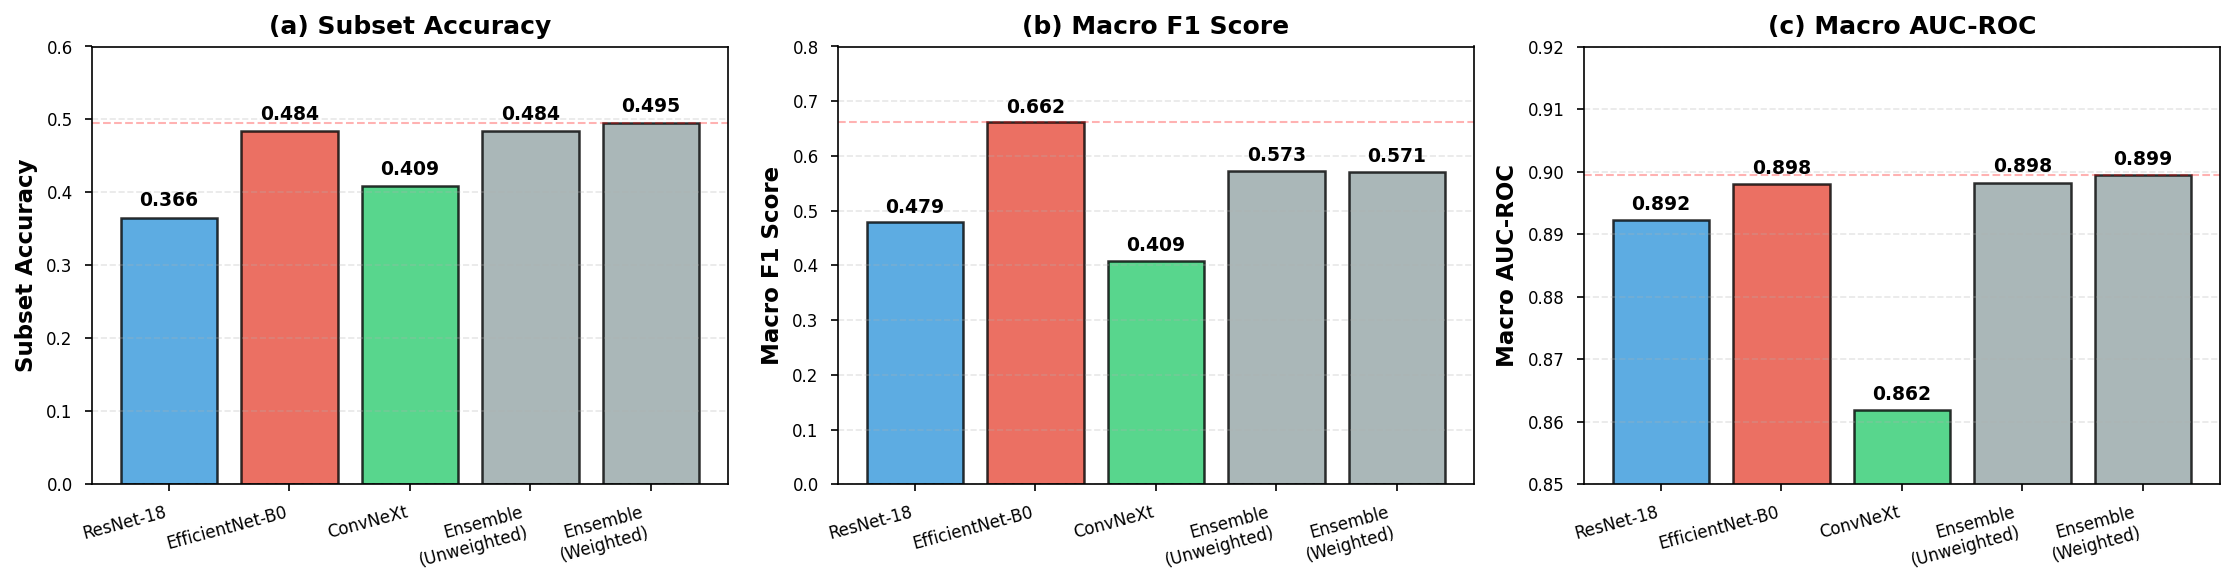

✓ Figure 1 saved: figure1_model_comparison.png

Creating Figure 2: Per-Class Performance Heatmap...


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-2153481786.py:34: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig('figure2_per_class_performance.png', bbox_inches='tight', dpi=300)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


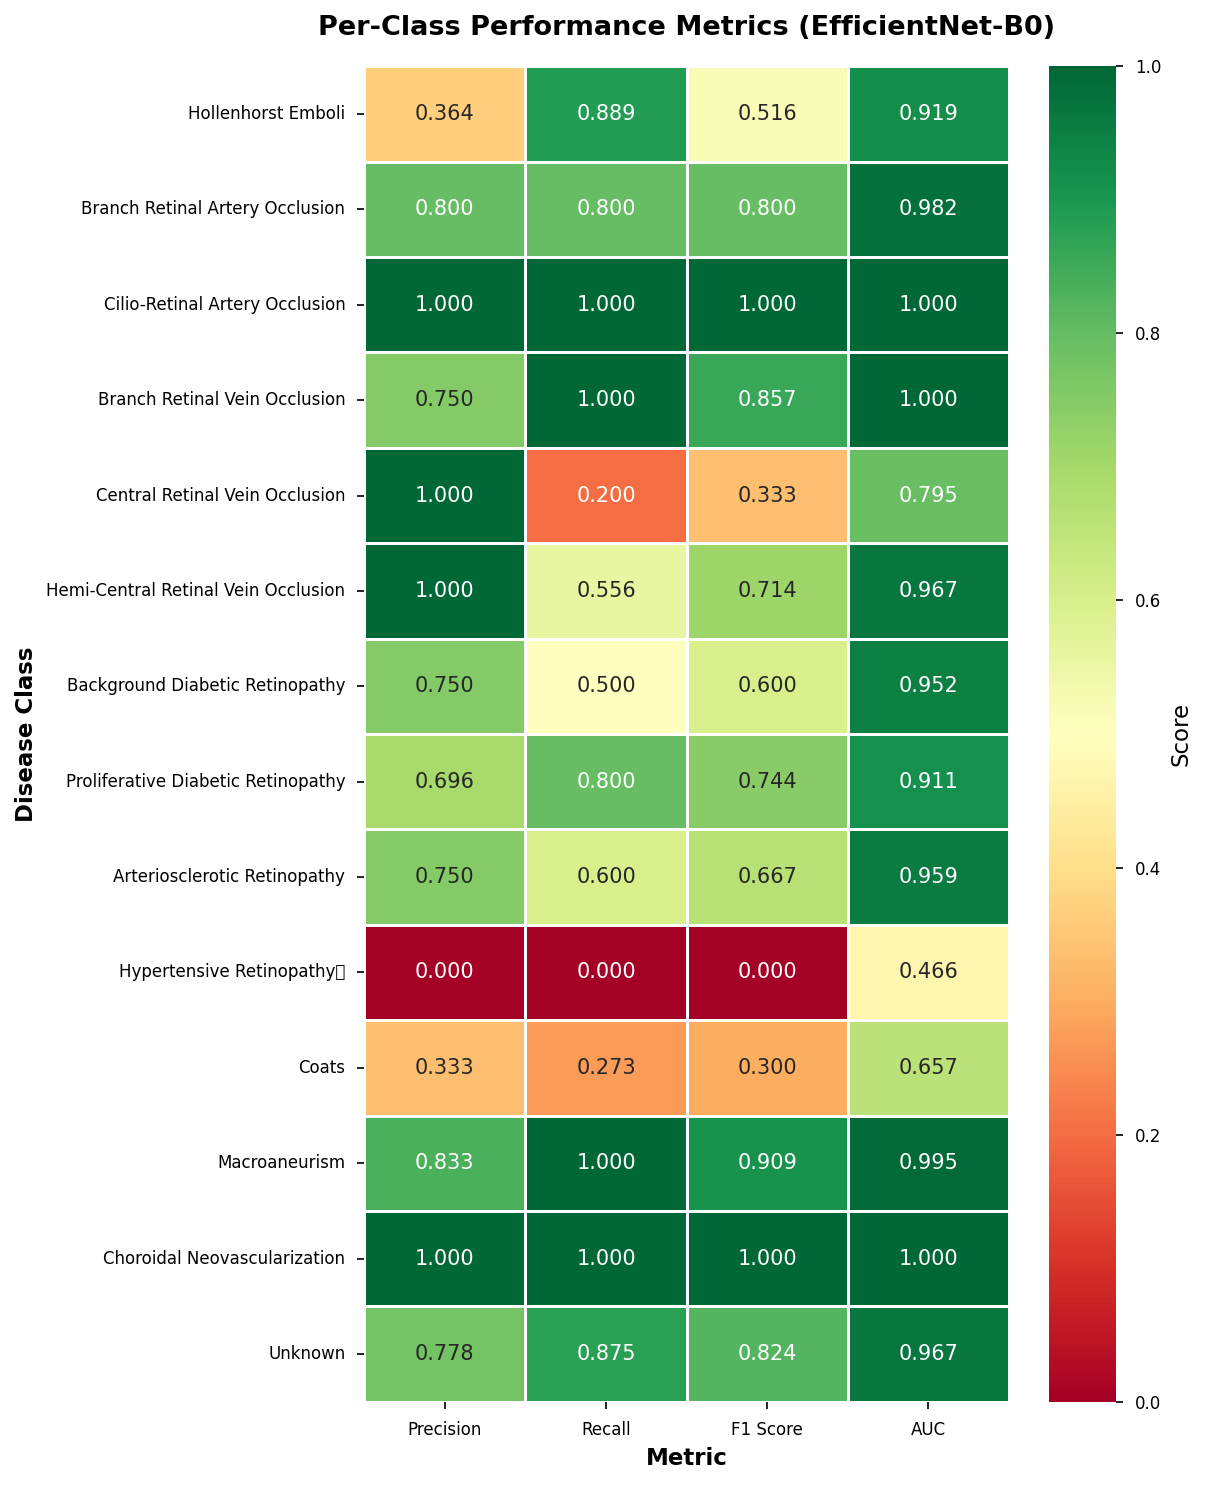

✓ Figure 2 saved: figure2_per_class_performance.png

Creating Figure 3: Training Curves...


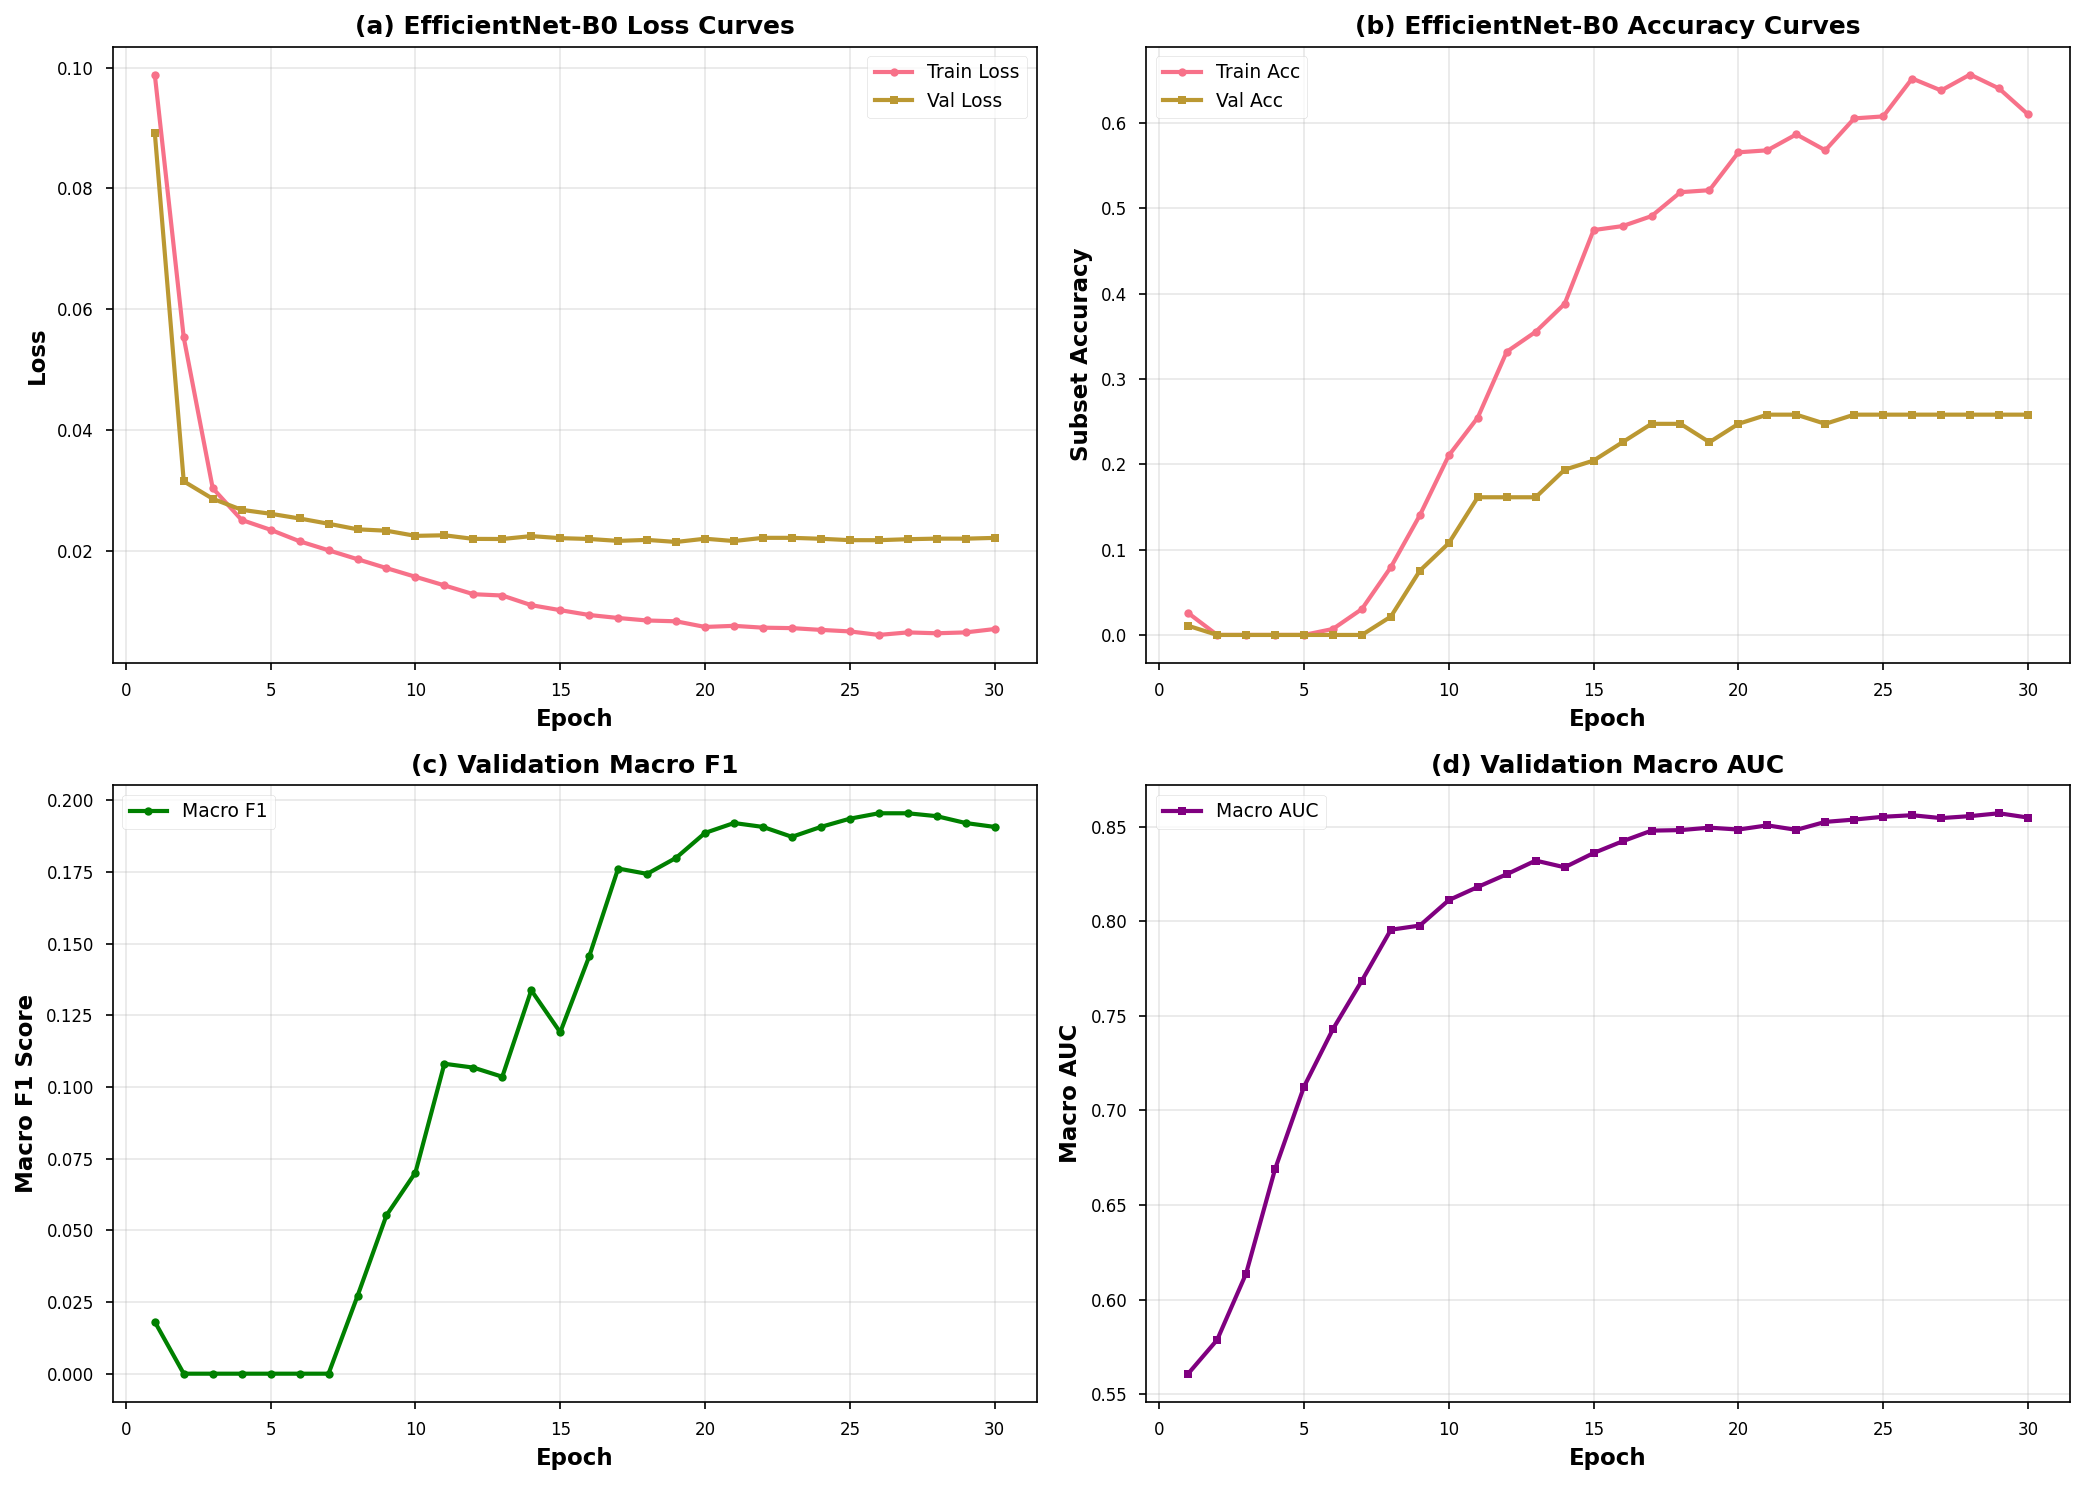

✓ Figure 3 saved: figure3_training_curves.png

Creating Figure 4: Multi-Model Loss Comparison...


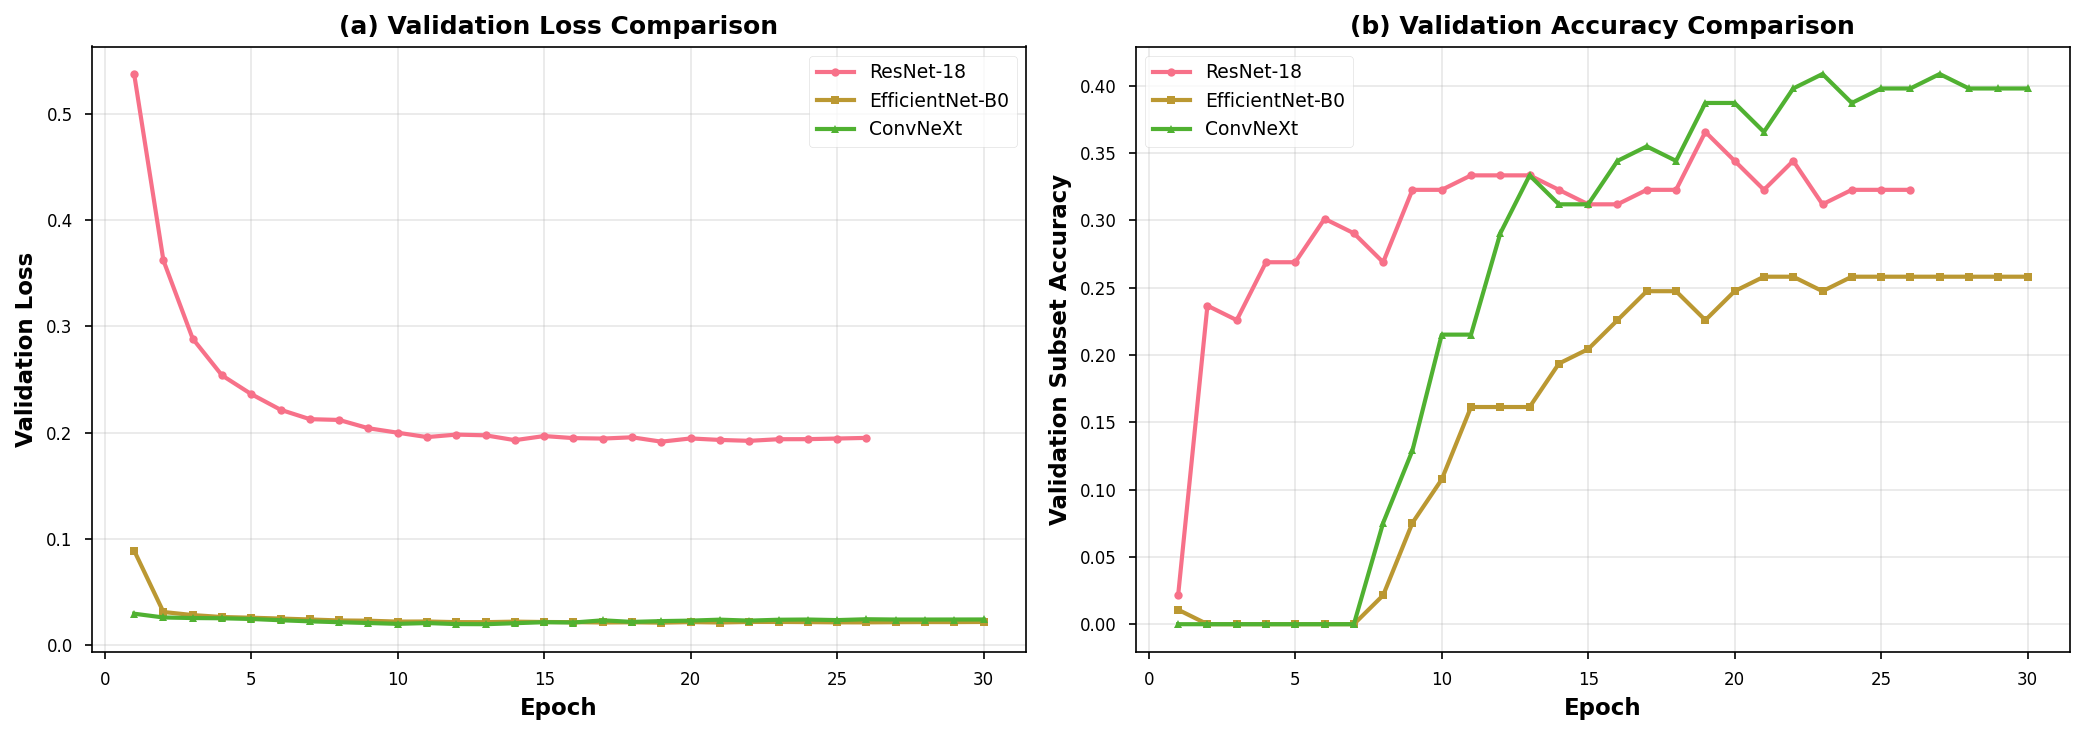

✓ Figure 4 saved: figure4_multi_model_loss.png

Creating Figure 5: Class Distribution Analysis...


/tmp/ipython-input-461328282.py:50: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-461328282.py:51: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig('figure5_class_distribution.png', bbox_inches='tight', dpi=300)


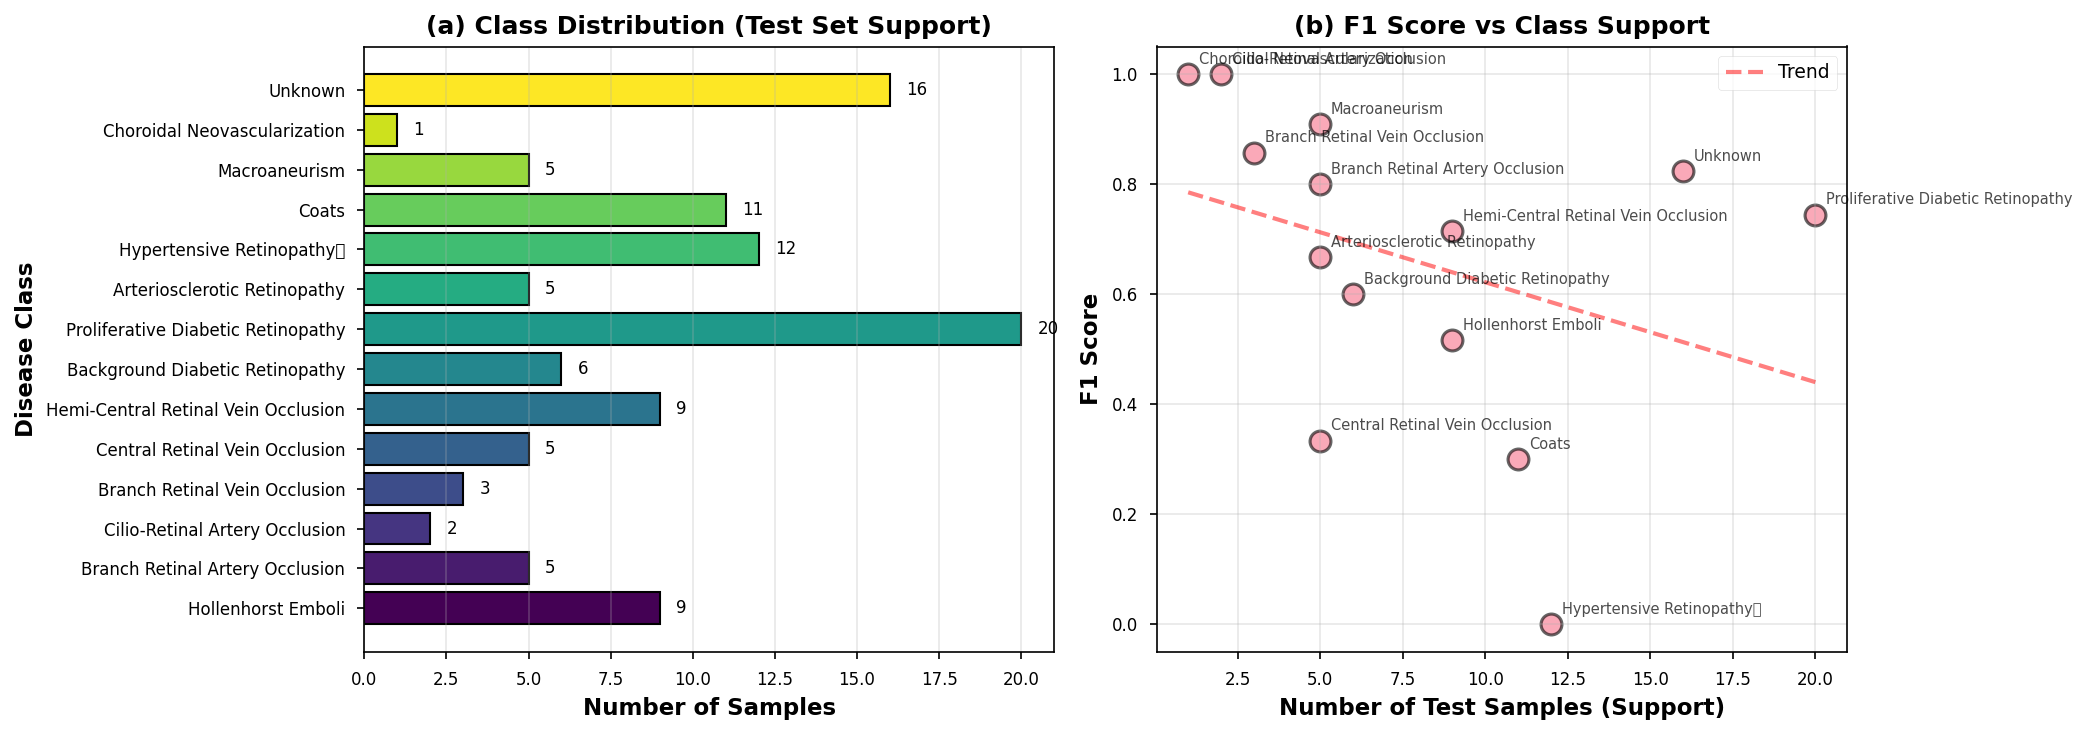

✓ Figure 5 saved: figure5_class_distribution.png

Creating Figure 6: Prediction Examples...


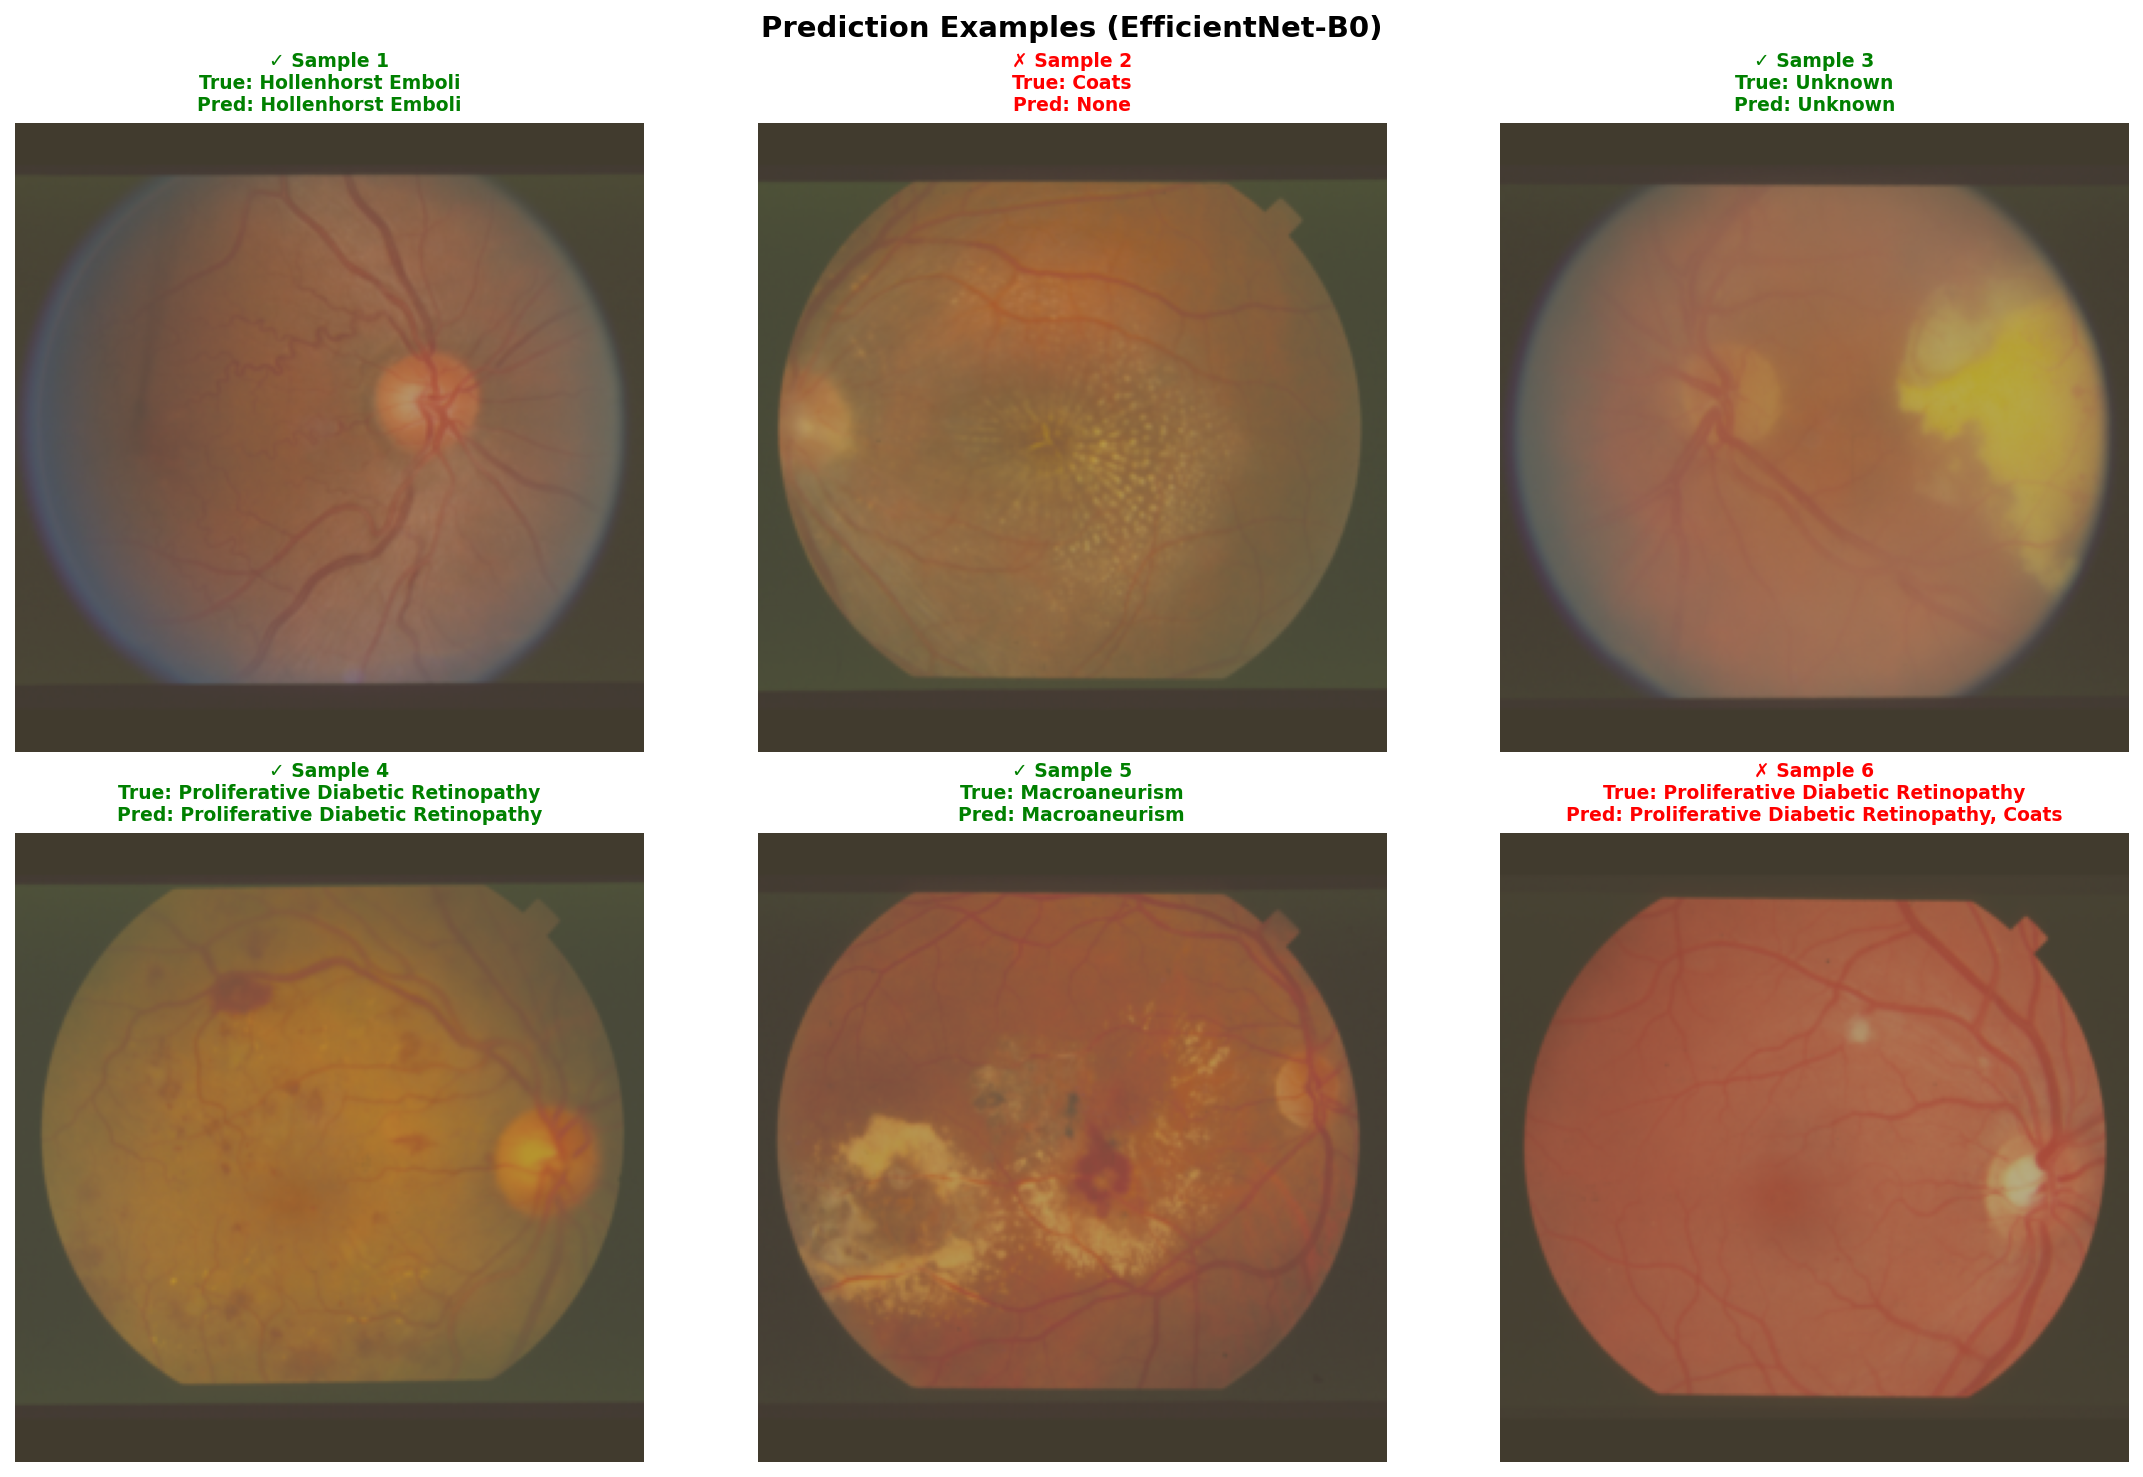

✓ Figure 6 saved: figure6_prediction_examples.png

Creating Figure 7: Disease Count Analysis...


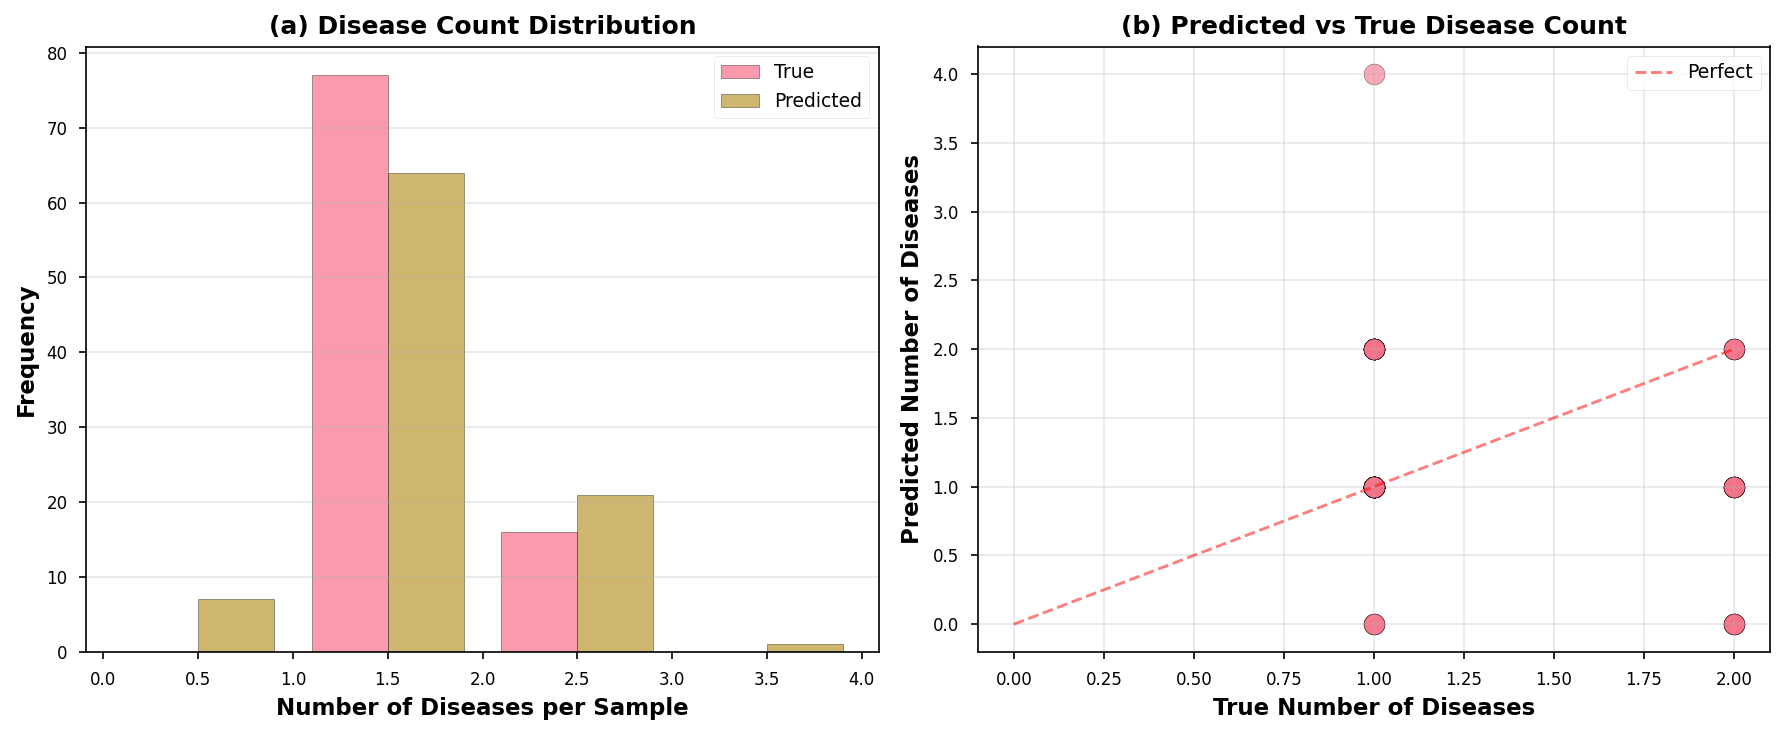

✓ Figure 7 saved: figure7_disease_count_analysis.png

ALL FIGURES GENERATED SUCCESSFULLY!

Files created:
  • figure1_model_comparison.png (MAIN RESULTS)
  • figure2_per_class_performance.png
  • figure3_training_curves.png
  • figure4_multi_model_loss.png
  • figure5_class_distribution.png
  • figure6_prediction_examples.png
  • figure7_disease_count_analysis.png


In [ ]:
disease_names = [
    'Hollenhorst Emboli', 'Branch Retinal Artery Occlusion', 'Cilio-Retinal Artery Occlusion', 'Branch Retinal Vein Occlusion',
    'Central Retinal Vein Occlusion', 'Hemi-Central Retinal Vein Occlusion', 'Background Diabetic Retinopathy', 'Proliferative Diabetic Retinopathy',
    'Arteriosclerotic Retinopathy', 'Hypertensive Retinopathy	', 'Coats',
    'Macroaneurism', 'Choroidal Neovascularization', 'Unknown'
]

# Generate all figures
generate_all_figures(
    resnet_metrics=resnet_metrics,
    efficientnet_metrics=efficientnet_metrics,
    convnext_metrics=convnext_metrics,
    ensemble_metrics=ensemble_metrics,
    ensemble_metrics_weighted=ensemble_metrics_weighted,
    resnet_history=resnet_history,
    efficientnet_history=efficientnet_history,
    convnext_history=convnext_history,
    efficientnet_model=efficientnet_model,
    test_loader=test_loader,
    device=device,
    disease_names=disease_names
)

In [ ]:
# Run this to get all the data I need
print("="*60)
print("COMPREHENSIVE METRICS FOR PAPER")
print("="*60)

# For each model (resnet_metrics, efficientnet_metrics, convnext_metrics)
for model_name, metrics in [("ResNet-18", resnet_metrics),
                             ("EfficientNet-B0", efficientnet_metrics),
                             ("ConvNeXt", convnext_metrics)]:
    print(f"\n{model_name}:")
    print(f"  Subset Accuracy: {metrics['subset_accuracy']:.4f}")
    print(f"  Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"  Macro Precision: {metrics.get('macro_precision', 'N/A')}")
    print(f"  Macro Recall: {metrics.get('macro_recall', 'N/A')}")
    print(f"  Macro F1: {metrics['macro_f1']:.4f}")
    print(f"  Macro AUC: {metrics['macro_auc']:.4f}")
    print(f"  Micro Precision: {metrics.get('micro_precision', 'N/A')}")
    print(f"  Micro Recall: {metrics.get('micro_recall', 'N/A')}")
    print(f"  Micro F1: {metrics['micro_f1']:.4f}")

    # Per-class
    print(f"\n  Per-Class F1: {metrics['per_class_f1']}")
    print(f"  Per-Class Precision: {metrics.get('per_class_precision', 'N/A')}")
    print(f"  Per-Class Recall: {metrics.get('per_class_recall', 'N/A')}")
    print(f"  Per-Class AUC: {metrics.get('per_class_auc', 'N/A')}")
    print(f"  Per-Class Support: {metrics.get('per_class_support', 'N/A')}")

# Training history
print("\n" + "="*60)
print("TRAINING HISTORY")
print("="*60)
print(f"\nEfficientNet epochs trained: {len(efficientnet_history['train_loss'])}")
print(f"Final train loss: {efficientnet_history['train_loss'][-1]:.4f}")
print(f"Final val loss: {efficientnet_history['val_loss'][-1]:.4f}")
print(f"Best val F1: {max(efficientnet_history.get('val_macro_f1', [0])):.4f}")

COMPREHENSIVE METRICS FOR PAPER

ResNet-18:
  Subset Accuracy: 0.3656
  Hamming Loss: 0.0630
  Macro Precision: N/A
  Macro Recall: N/A
  Macro F1: 0.4793
  Macro AUC: 0.8923
  Micro Precision: 0.7368421052631579
  Micro Recall: 0.3853211009174312
  Micro F1: 0.5060

  Per-Class F1: [0.66666667 0.57142857 0.66666667 0.5        0.         0.36363636
 0.28571429 0.61904762 0.57142857 0.         0.15384615 0.57142857
 1.         0.74074074]
  Per-Class Precision: [0.66666667 1.         1.         1.         0.         1.
 1.         0.59090909 1.         0.         0.5        1.
 1.         0.90909091]
  Per-Class Recall: [0.66666667 0.4        0.5        0.33333333 0.         0.22222222
 0.16666667 0.65       0.4        0.         0.09090909 0.4
 1.         0.625     ]
  Per-Class AUC: [0.95238095 0.99090909 0.95054945 0.98148148 0.89090909 0.92592593
 0.89463602 0.85479452 0.96363636 0.41152263 0.69512195 0.99772727
 1.         0.98214286]
  Per-Class Support: [ 9  5  2  3  5  9  6 20  